# DCGAN - Deep Convolutional GanS

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
tf.__version__

'2.10.0'

## Montando o dataset

In [2]:
(x_treinamento, y_treinamento),(_,_) = tf.keras.datasets.fashion_mnist.load_data()

In [3]:
x_treinamento.shape,y_treinamento.shape

((60000, 28, 28), (60000,))

9


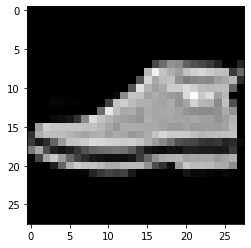

In [4]:
i = np.random.randint(0,60000)
print(y_treinamento[i])
plt.imshow(x_treinamento[i],cmap='gray');

In [5]:
x_treinamento = x_treinamento.reshape(x_treinamento.shape[0],28,28,1).astype('float32')
x_treinamento.shape

(60000, 28, 28, 1)

In [6]:
x_treinamento[0].min(),x_treinamento[0].max() #255 -> escuro 0 -> claro

(0.0, 255.0)

In [7]:
#gans recomendavel valores entre -1 e 1
x_treinamento = (x_treinamento - 127.5) / 127.5
x_treinamento[0].min(),x_treinamento[0].max() #255 -> escuro 0 -> claro

(-1.0, 1.0)

In [8]:
buffer_size = x_treinamento.shape[0]
batch_size = 256

In [9]:
type(x_treinamento)

numpy.ndarray

In [10]:
x_treinamento = tf.data.Dataset.from_tensor_slices(x_treinamento).shuffle(buffer_size).batch(batch_size)

In [11]:
type(x_treinamento)

tensorflow.python.data.ops.dataset_ops.BatchDataset

In [12]:
x_treinamento

<BatchDataset element_spec=TensorSpec(shape=(None, 28, 28, 1), dtype=tf.float32, name=None)>

## Construção do Gerador 

In [13]:
def cria_gerador():
    network = tf.keras.Sequential()
    
    network.add(layers.Dense(units = 7*7*256, use_bias = False,input_shape=(100,)))
    network.add(layers.BatchNormalization())
    network.add(layers.LeakyReLU())
    
    network.add(layers.Reshape((7,7,256)))
    
    network.add(layers.Conv2DTranspose(filters=128,kernel_size=(5,5),padding='same',use_bias=False))
    network.add(layers.BatchNormalization())
    network.add(layers.LeakyReLU())
    
    network.add(layers.Conv2DTranspose(filters=64,kernel_size=(5,5),padding='same',use_bias=False,strides=(2,2)))
    network.add(layers.BatchNormalization())
    network.add(layers.LeakyReLU()) 
    
    network.add(layers.Conv2DTranspose(filters=1,kernel_size=(5,5),padding='same',use_bias=False,strides=(2,2),activation='tanh'))
    
    network.summary()
    return network

In [14]:
gerador = cria_gerador()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 12544)             1254400   
                                                                 
 batch_normalization (BatchN  (None, 12544)            50176     
 ormalization)                                                   
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 12544)             0         
                                                                 
 reshape (Reshape)           (None, 7, 7, 256)         0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 7, 7, 128)        819200    
 nspose)                                                         
                                                                 
 batch_normalization_1 (Batc  (None, 7, 7, 128)        5

In [15]:
gerador.input

<KerasTensor: shape=(None, 100) dtype=float32 (created by layer 'dense_input')>

In [16]:
ruido = tf.random.normal([1,100])
ruido

<tf.Tensor: shape=(1, 100), dtype=float32, numpy=
array([[-1.0120492 , -0.9575125 ,  2.2344205 ,  0.2278642 ,  2.5709941 ,
         0.66766924,  1.5874321 ,  0.17667726,  0.48165226, -0.58536714,
        -1.4871035 , -0.52111405,  1.8021129 ,  0.19420373,  2.0139987 ,
        -1.397242  , -0.12958956,  0.54974973, -0.7057556 , -2.004642  ,
        -0.16940735,  0.5234512 , -0.03212737, -1.2657493 ,  1.4601822 ,
         0.8704774 ,  2.9032934 ,  1.636189  , -1.4398308 ,  1.4715673 ,
        -0.9090039 , -0.9761814 ,  1.9156222 ,  0.40583107, -0.52305764,
         0.37188175,  1.2727541 ,  0.5978142 ,  1.5986724 , -0.14805555,
        -1.7165132 ,  0.22056423,  0.4268888 , -1.6719323 ,  0.9980112 ,
         1.8640399 , -0.87021357, -0.38820848, -0.54842347, -1.8295856 ,
        -0.20140082,  0.5818034 , -0.58417255, -0.35151774,  1.1077766 ,
         0.04745534, -1.867233  ,  1.5425131 ,  0.61535364, -0.36509353,
         0.48059908, -0.71757555,  1.4544733 , -0.567147  , -2.349946  ,
 

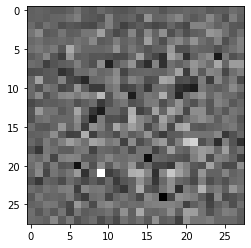

In [17]:
imagem_gerada = gerador(ruido,training =False)
plt.imshow(imagem_gerada[0,:,:,0],cmap='gray')

## Construção do Discriminador

In [18]:
def cria_discriminador():
    network = tf.keras.Sequential()
    
    network.add(layers.Conv2D(filters=64,strides=(2,2),kernel_size=(5,5),padding='same',input_shape=[28,28,1]))
    network.add(layers.LeakyReLU())
    network.add(layers.Dropout(0.3))
    
    network.add(layers.Conv2D(filters=128,strides=(2,2),kernel_size=(5,5),padding='same'))
    network.add(layers.LeakyReLU())
    network.add(layers.Dropout(0.3))    
    
    network.add(layers.Flatten())
    network.add(layers.Dense(1))
    network.summary()
    return network

In [19]:
discriminador = cria_discriminador()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 14, 14, 64)        1664      
                                                                 
 leaky_re_lu_3 (LeakyReLU)   (None, 14, 14, 64)        0         
                                                                 
 dropout (Dropout)           (None, 14, 14, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 7, 7, 128)         204928    
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 7, 7, 128)         0         
                                                                 
 dropout_1 (Dropout)         (None, 7, 7, 128)         0         
                                                                 
 flatten (Flatten)           (None, 6272)             

In [20]:
discriminador(imagem_gerada,training = False)

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[-0.00242387]], dtype=float32)>

# Calculo do Erro

In [21]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [22]:
def discriminador_loss(expected_output,fake_output):
    real_loss = cross_entropy(tf.ones_like(expected_output),expected_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output),fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

In [23]:
def gerador_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output),fake_output)

In [24]:
gerador_optimizer = tf.keras.optimizers.Adam(learning_rate=0.00001)
discriminador_optimizer = tf.keras.optimizers.Adam(learning_rate=0.00001)

# Treinamento

In [25]:
epocas = 100
dimensao_ruido = 100
numero_imagens = 16

In [26]:
@tf.function
def treinamento(imagens):
    ruido = tf.random.normal([batch_size,dimensao_ruido])
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        imagens_geradas = gerador(ruido,training= True)
    
        expected_output = discriminador(imagens, training = True)
        fake_output = discriminador(imagens_geradas,training=True)
        
        gen_loss = gerador_loss(fake_output)
        disc_loss = discriminador_loss(expected_output, fake_output)
        
    gradientes_gerador = gen_tape.gradient(gen_loss, gerador.trainable_variables)
    gradentes_discriminador = disc_tape.gradient(disc_loss,discriminador.trainable_variables)
    
    gerador_optimizer.apply_gradients(zip(gradientes_gerador,gerador.trainable_variables))
    discriminador_optimizer.apply_gradients(zip(gradentes_discriminador,discriminador.trainable_variables))

In [27]:
imagens_teste = tf.random.normal([numero_imagens,dimensao_ruido])

In [29]:
def treina_gan(dataset, epocas,imagens_teste):
    for epoca in range(epocas):
        for imagem_batch in dataset:
            treinamento(imagem_batch)
            
        print('Epoca: ',epoca+1)
        imagens_geradas = gerador(imagens_teste,training=False)
        fig = plt.figure(figsize=(10,10))
        for i in range(imagens_geradas.shape[0]):
            plt.subplot(4,4,i+1)
            plt.imshow(imagens_geradas[i,:,:,0]*127.5 +127.5,cmap='gray')
            plt.axis('off')
        plt.show()

Epoca:  1


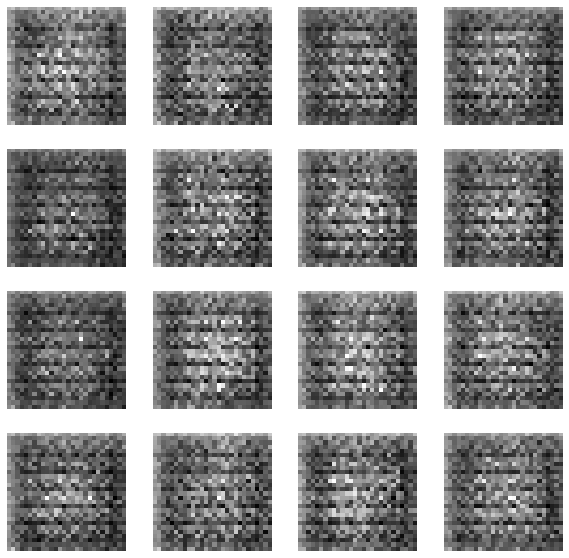

Epoca:  2


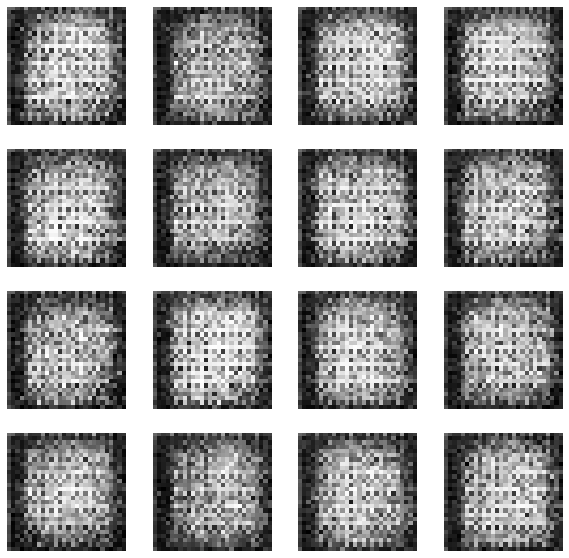

Epoca:  3


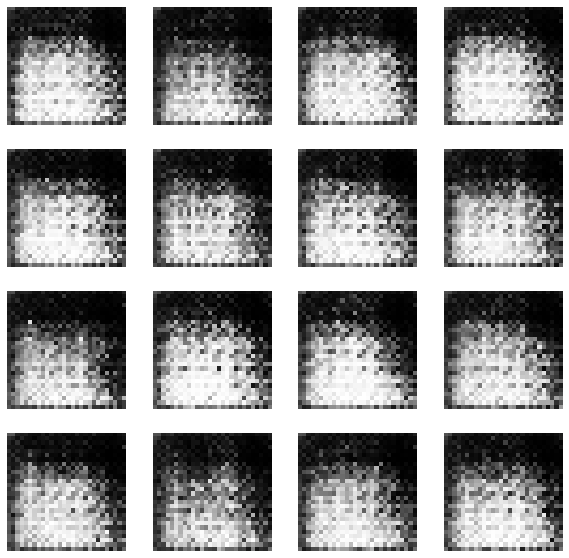

Epoca:  4


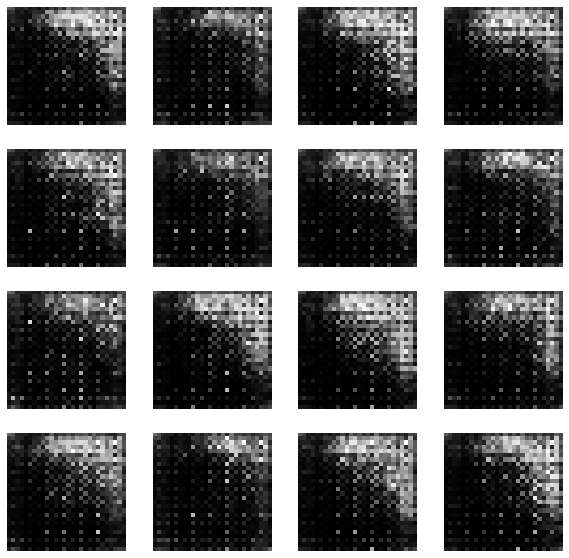

Epoca:  5


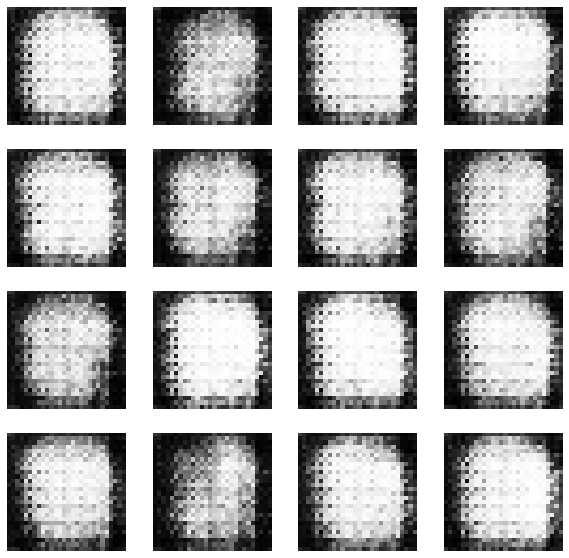

Epoca:  6


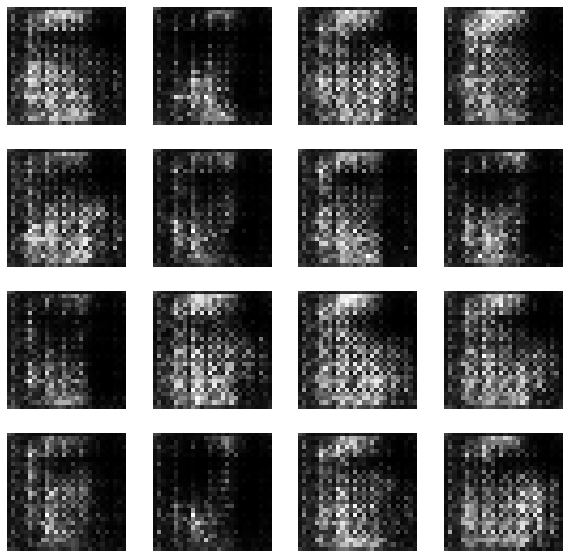

Epoca:  7


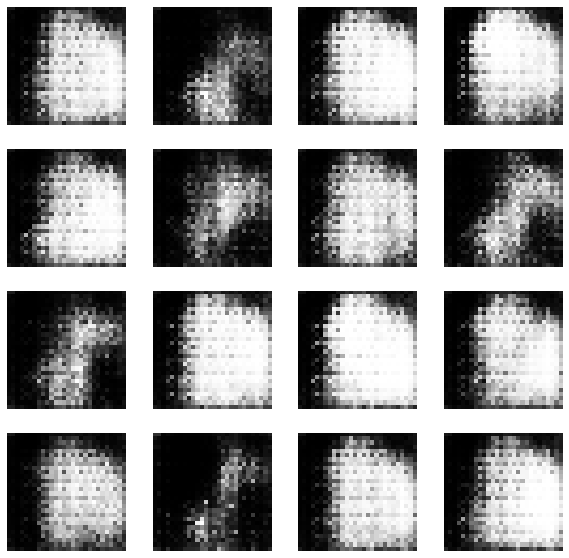

Epoca:  8


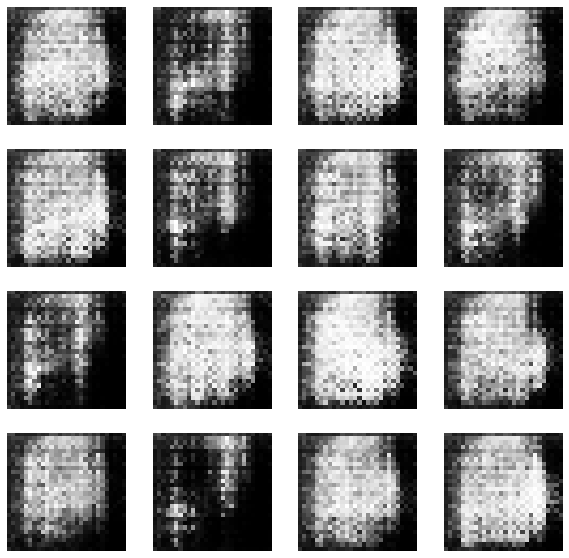

Epoca:  9


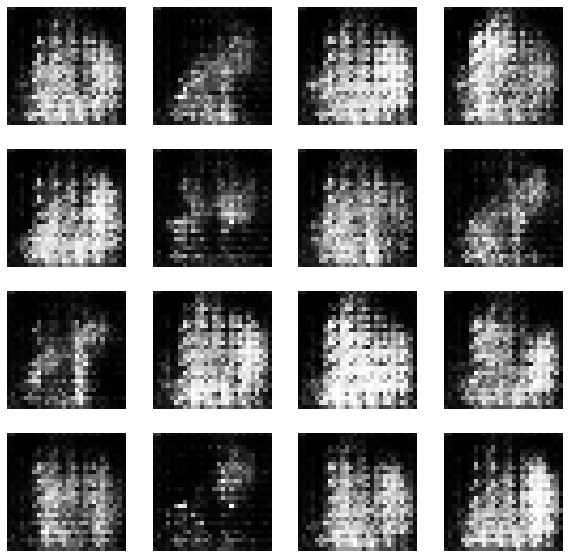

Epoca:  10


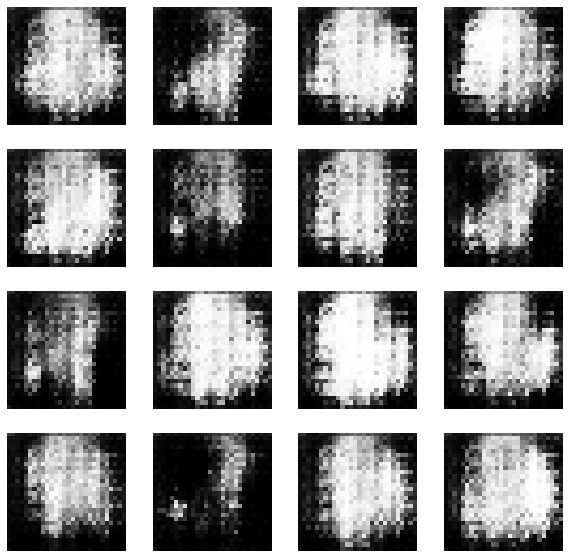

Epoca:  11


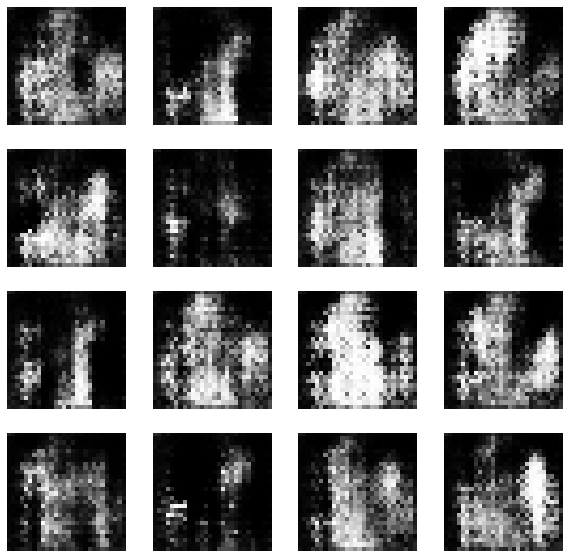

Epoca:  12


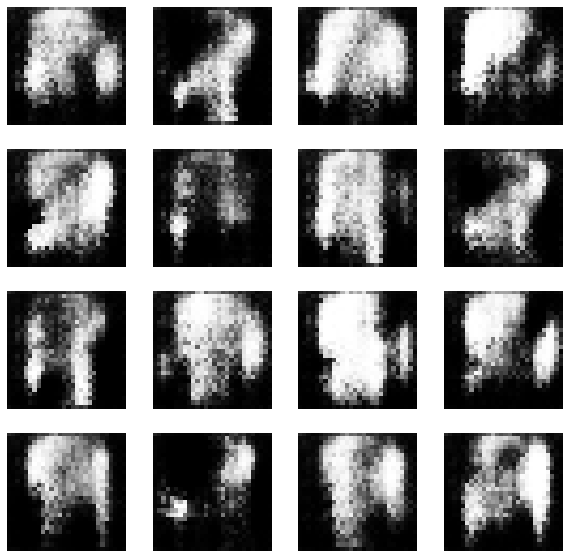

Epoca:  13


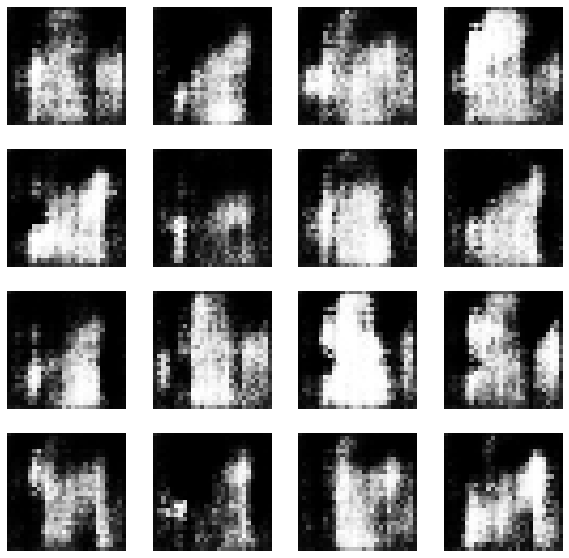

Epoca:  14


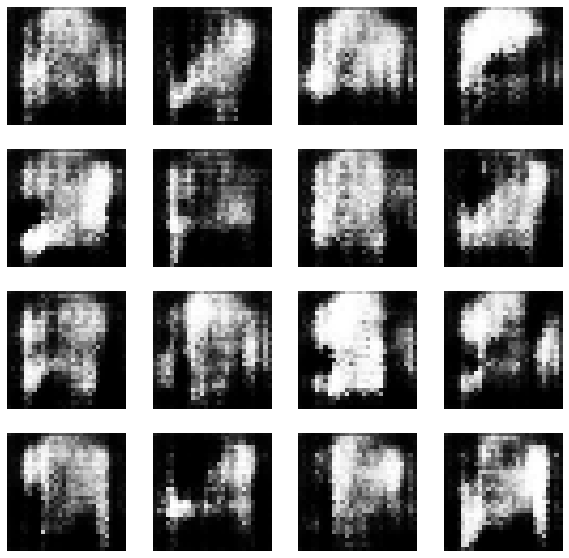

Epoca:  15


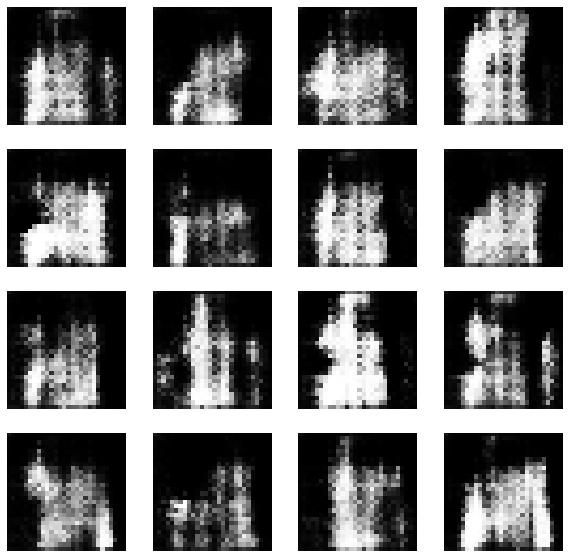

Epoca:  16


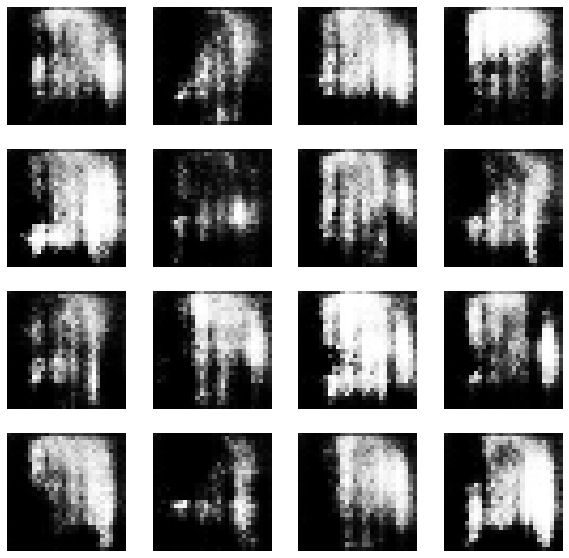

Epoca:  17


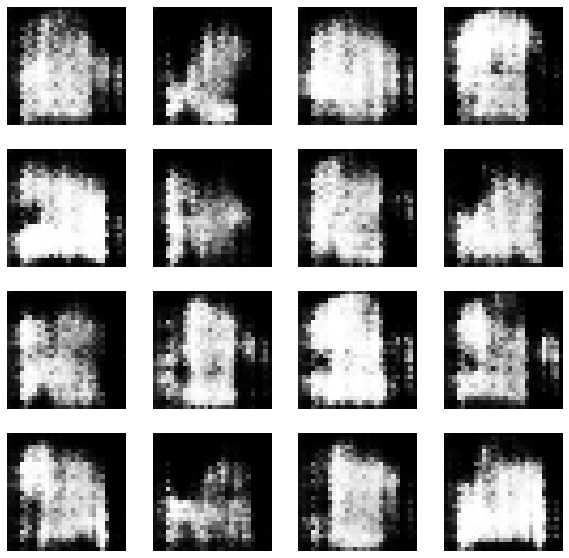

Epoca:  18


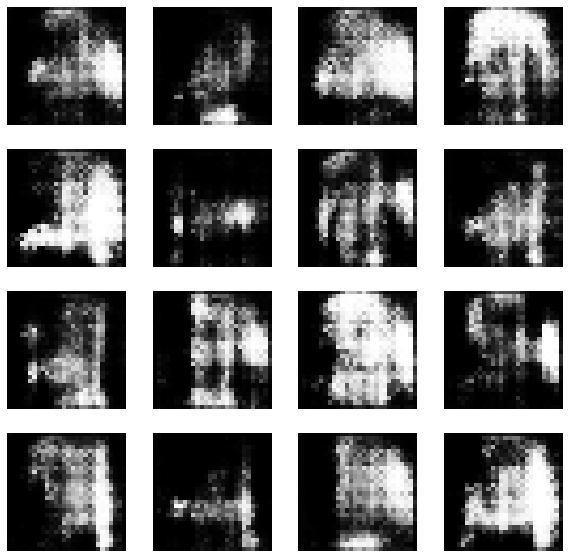

Epoca:  19


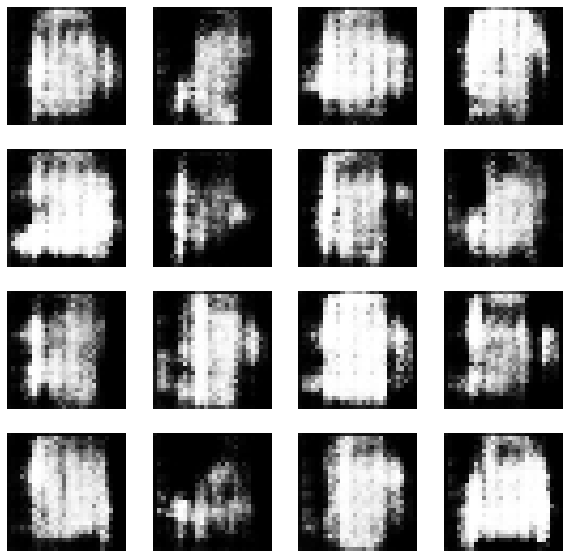

Epoca:  20


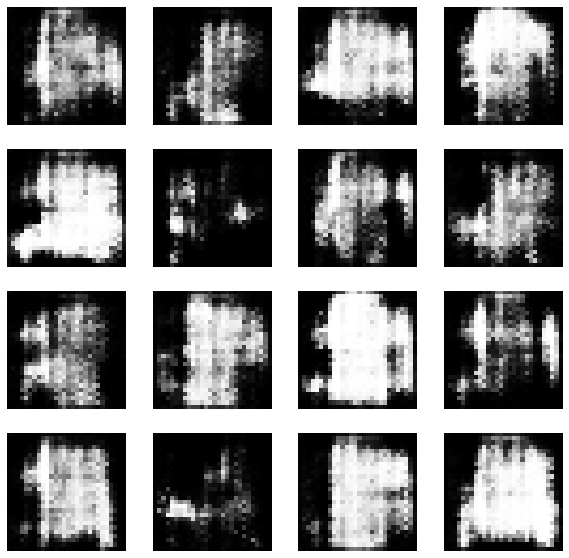

Epoca:  21


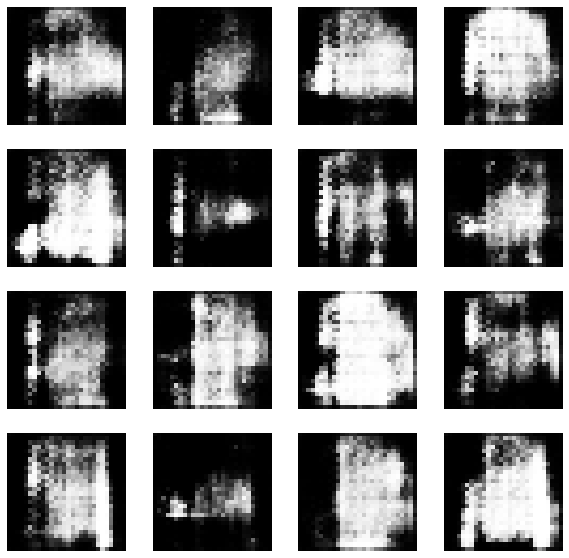

Epoca:  22


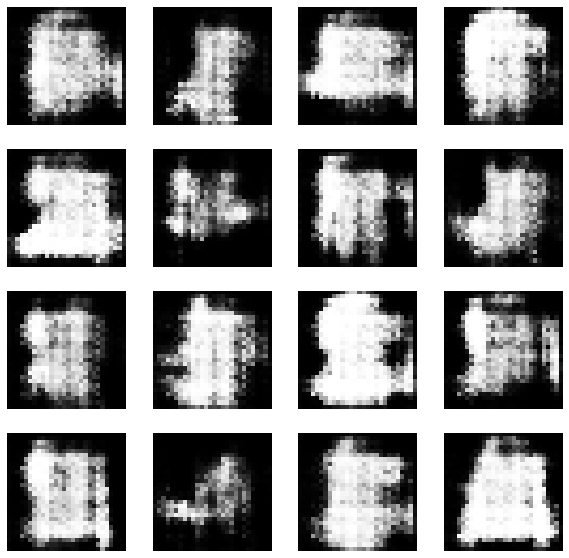

Epoca:  23


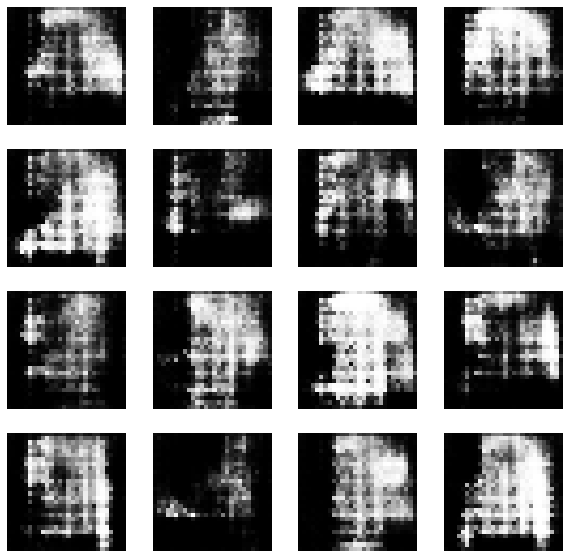

Epoca:  24


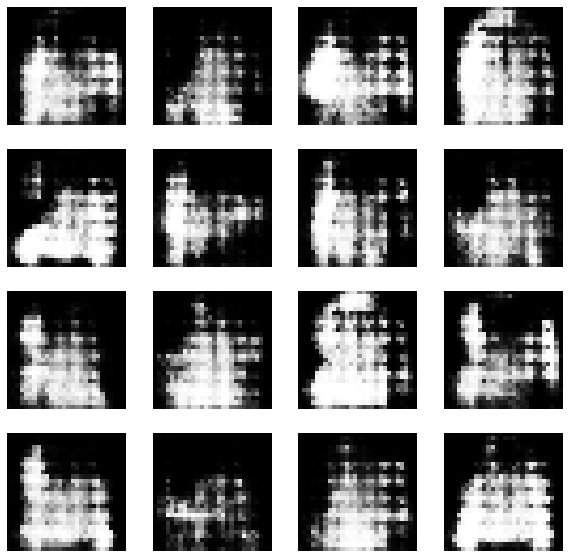

Epoca:  25


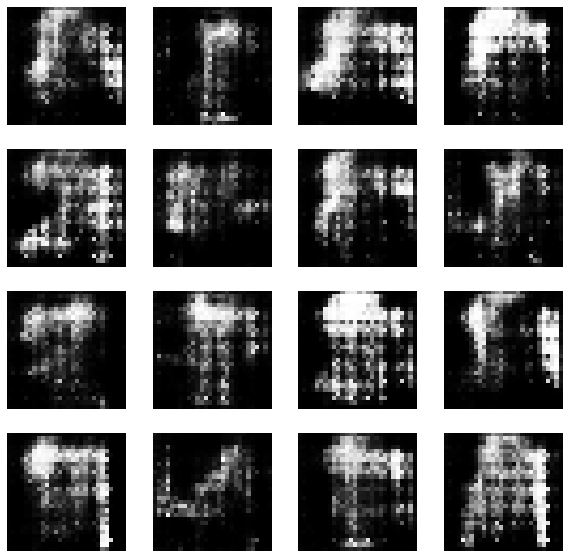

Epoca:  26


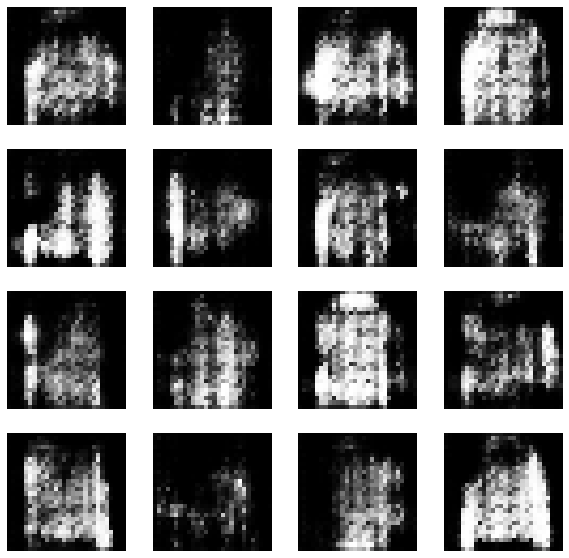

Epoca:  27


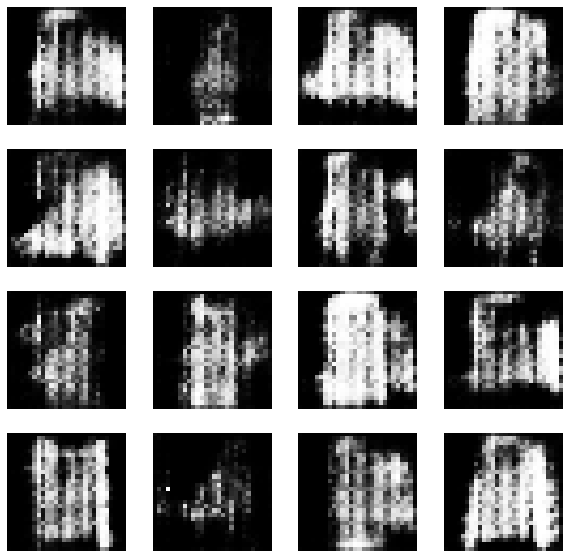

Epoca:  28


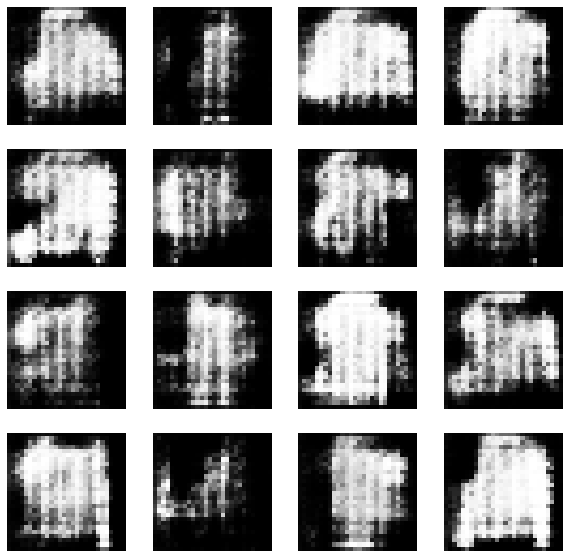

Epoca:  29


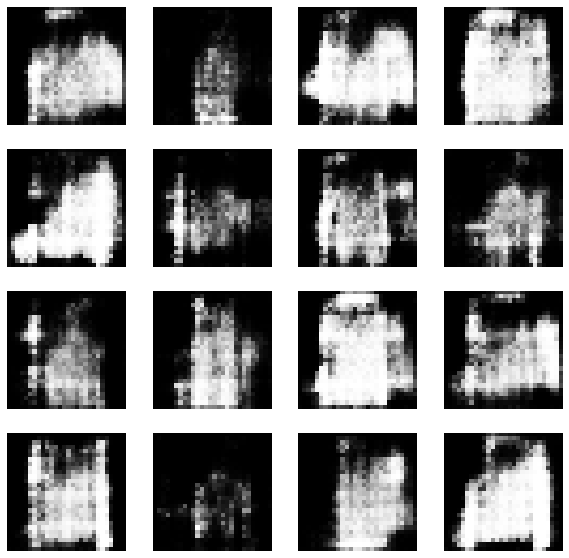

Epoca:  30


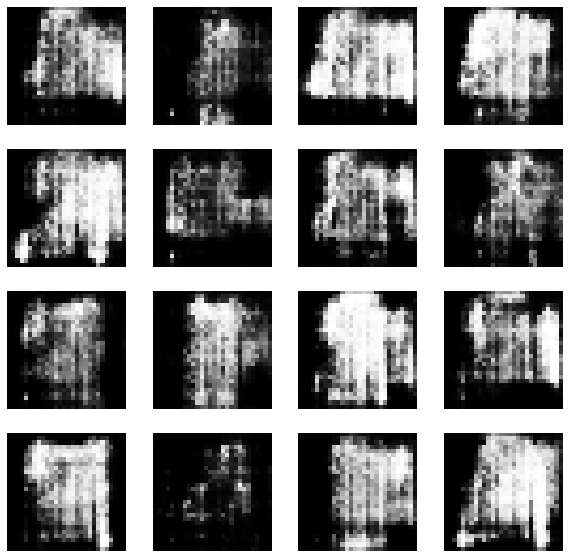

Epoca:  31


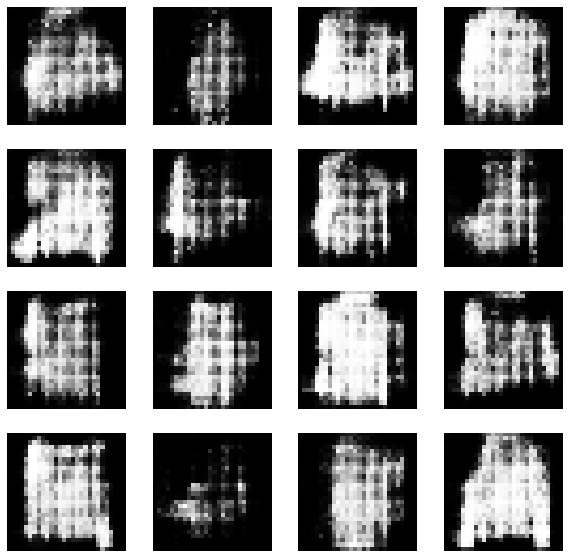

Epoca:  32


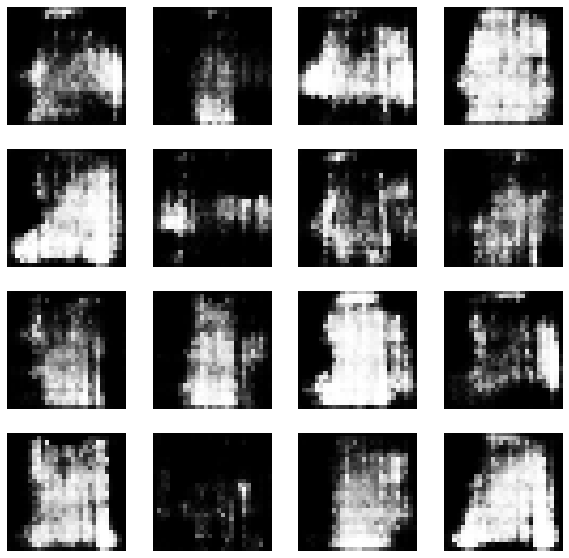

Epoca:  33


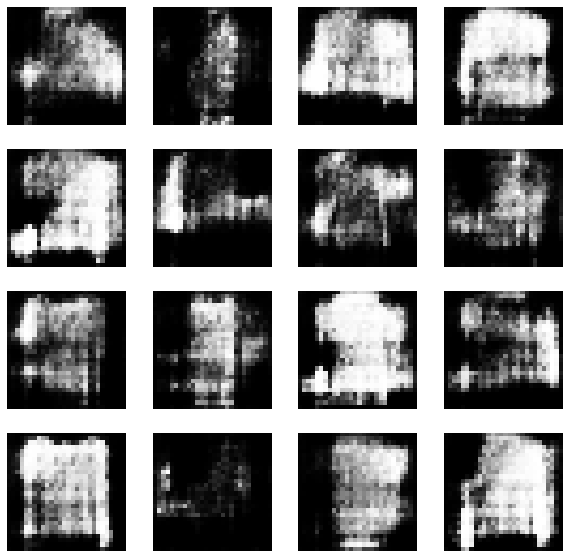

Epoca:  34


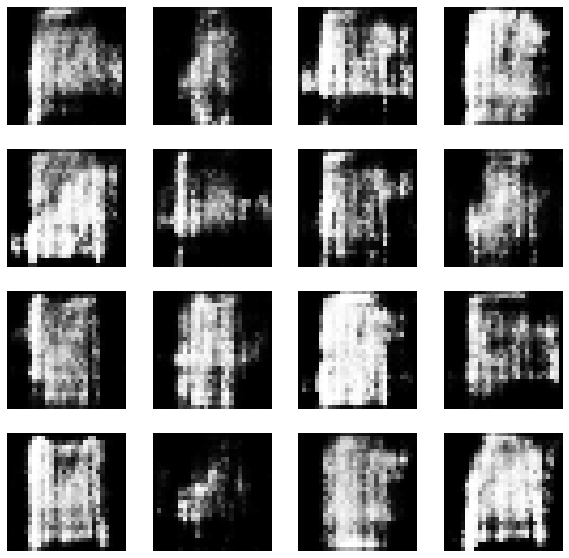

Epoca:  35


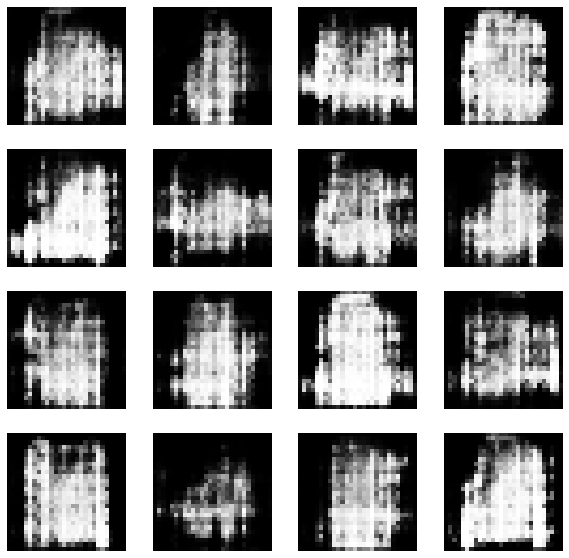

Epoca:  36


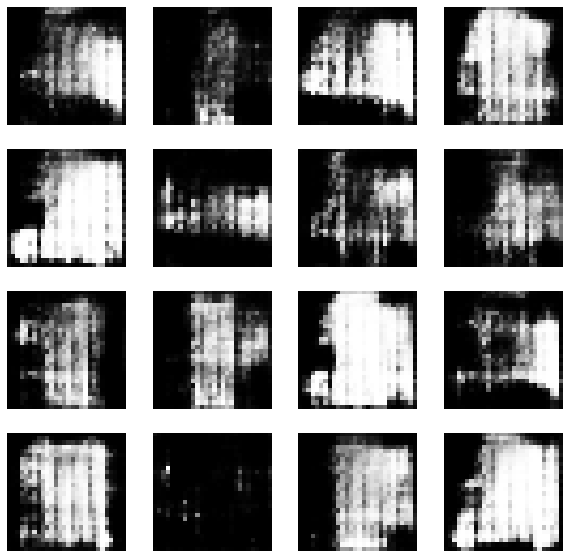

Epoca:  37


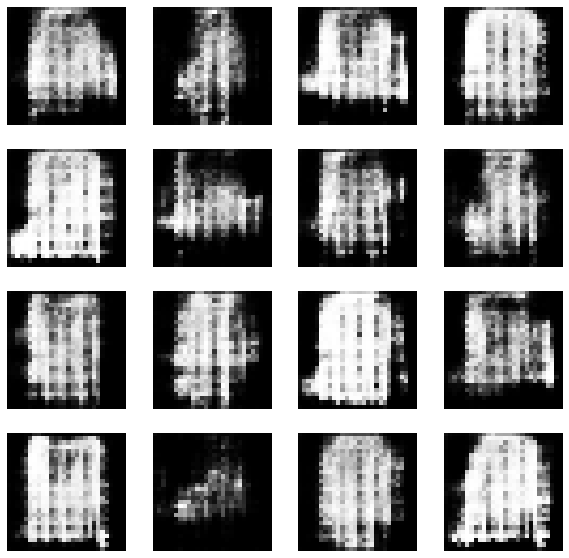

Epoca:  38


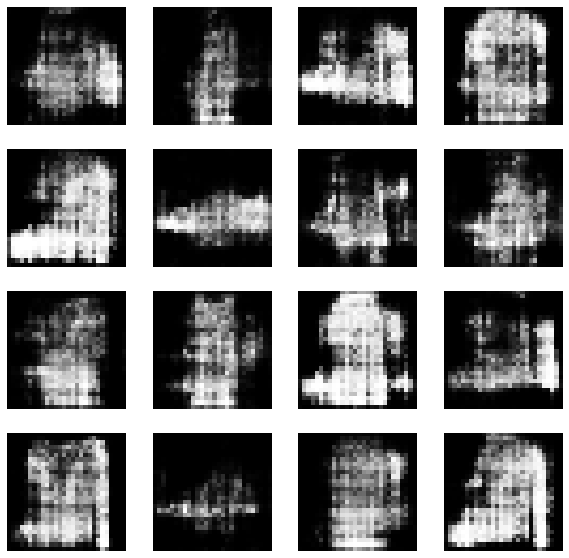

Epoca:  39


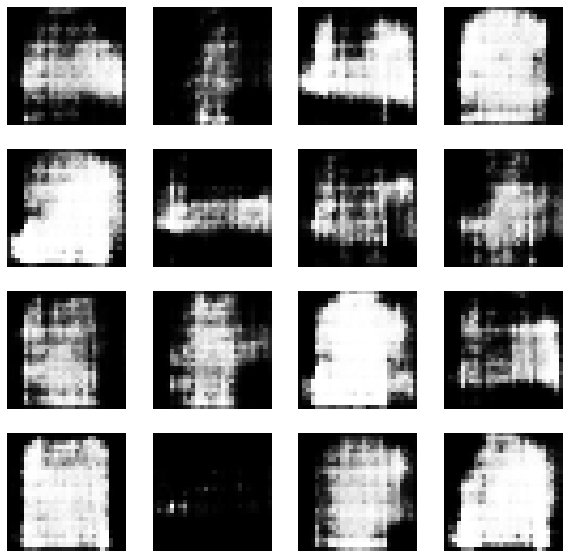

Epoca:  40


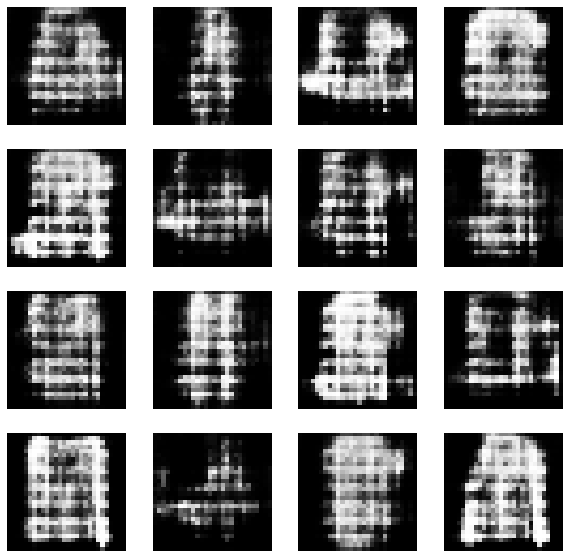

Epoca:  41


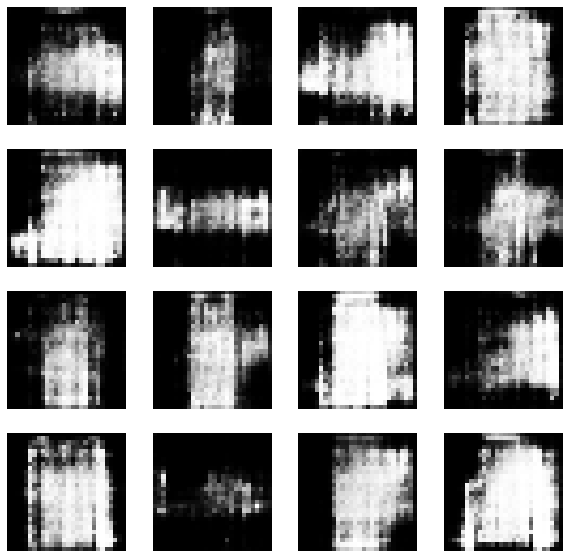

Epoca:  42


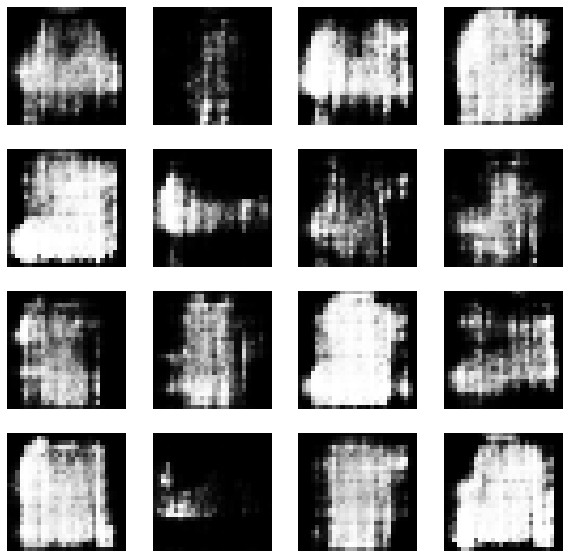

Epoca:  43


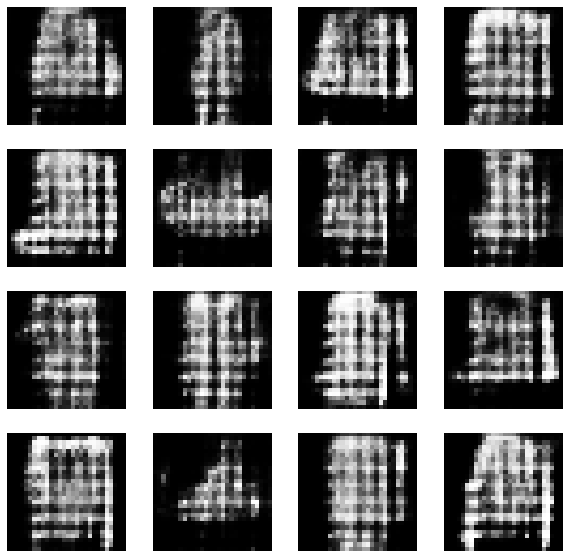

Epoca:  44


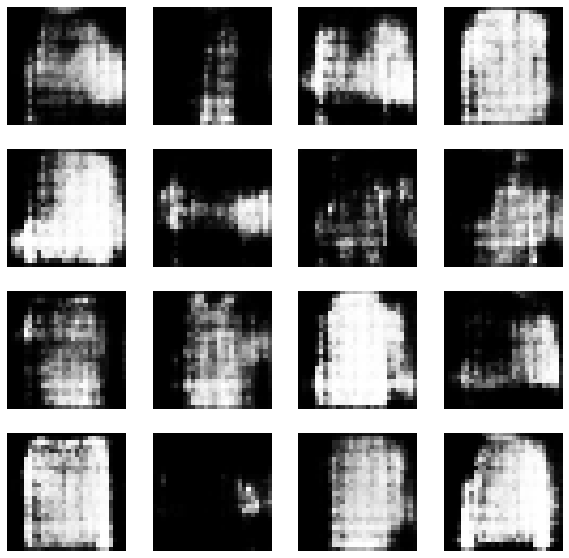

Epoca:  45


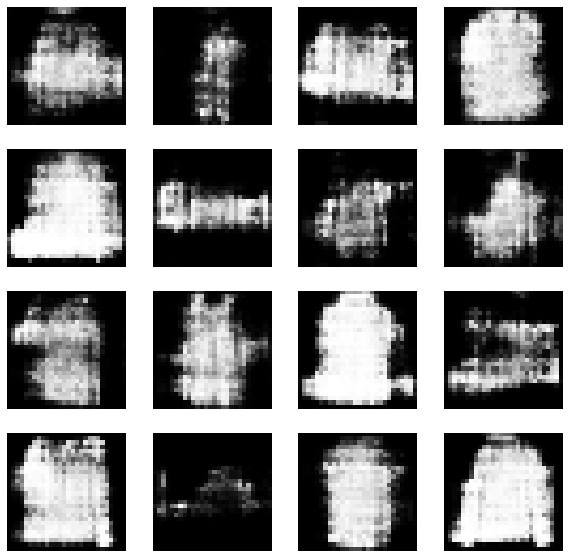

Epoca:  46


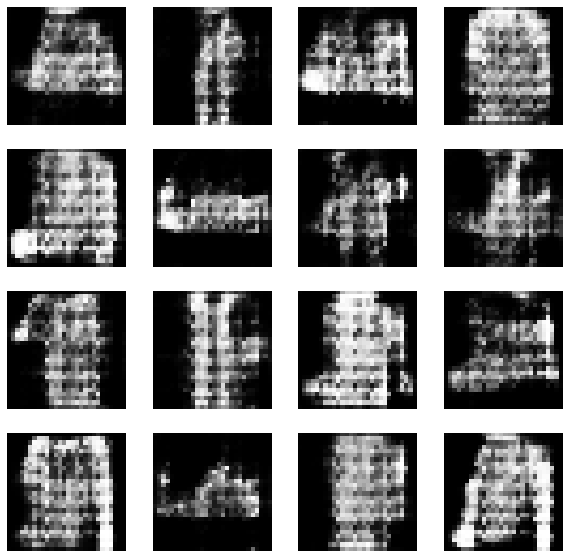

Epoca:  47


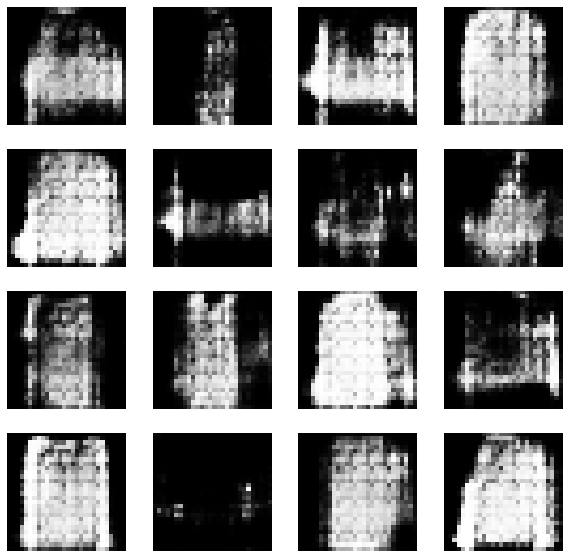

Epoca:  48


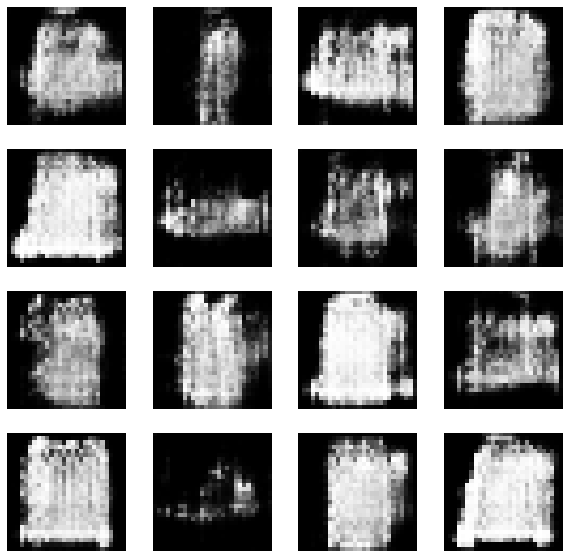

Epoca:  49


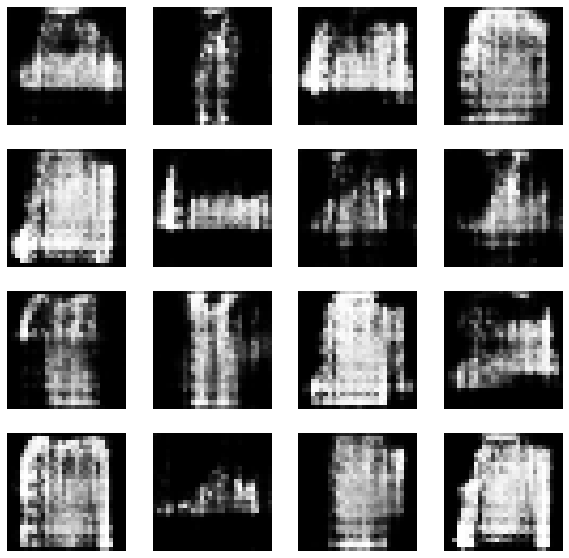

Epoca:  50


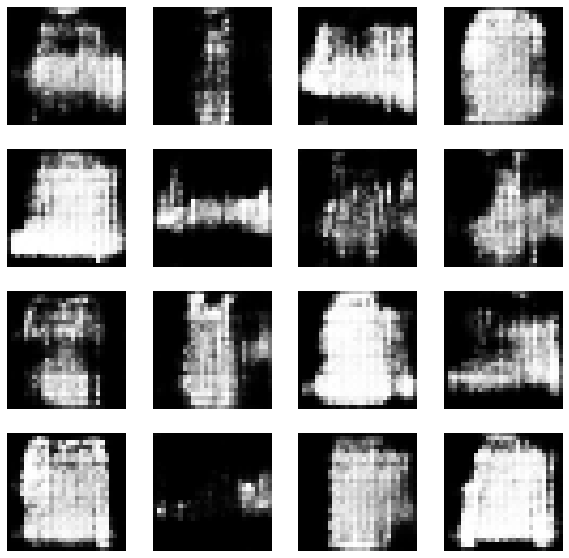

Epoca:  51


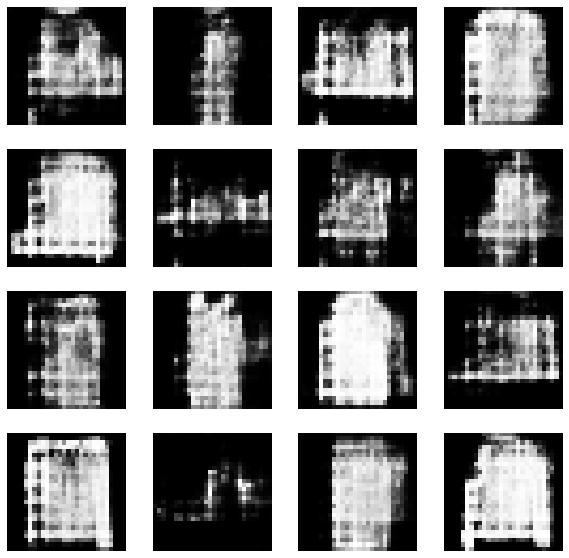

Epoca:  52


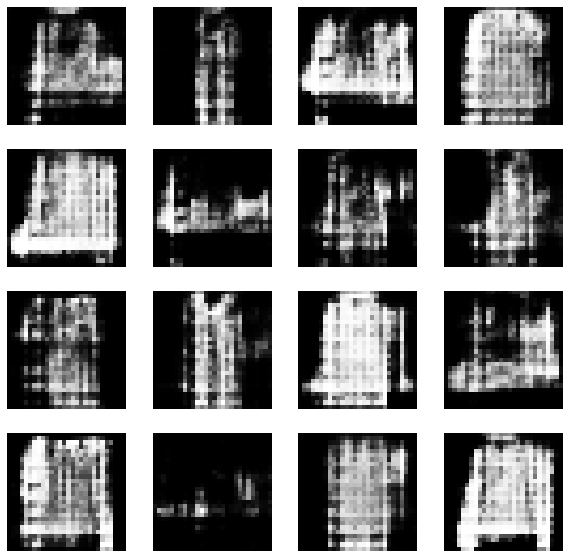

Epoca:  53


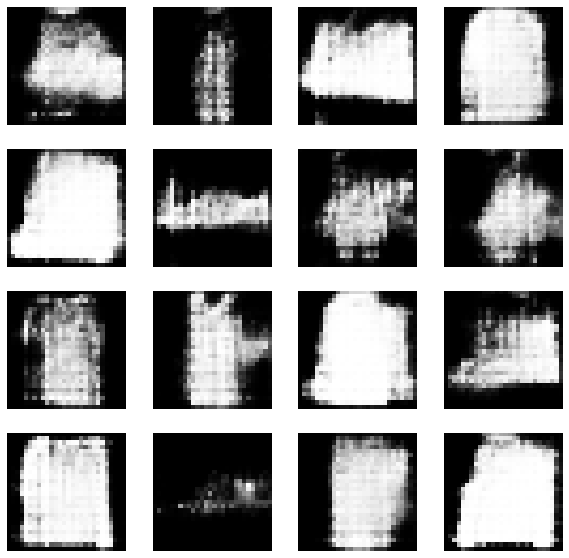

Epoca:  54


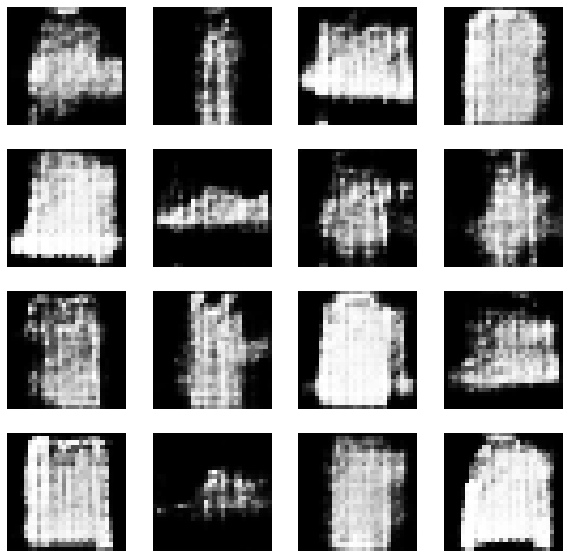

Epoca:  55


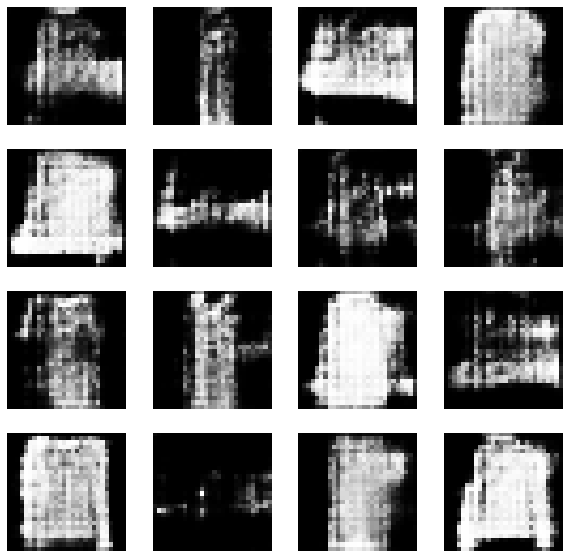

Epoca:  56


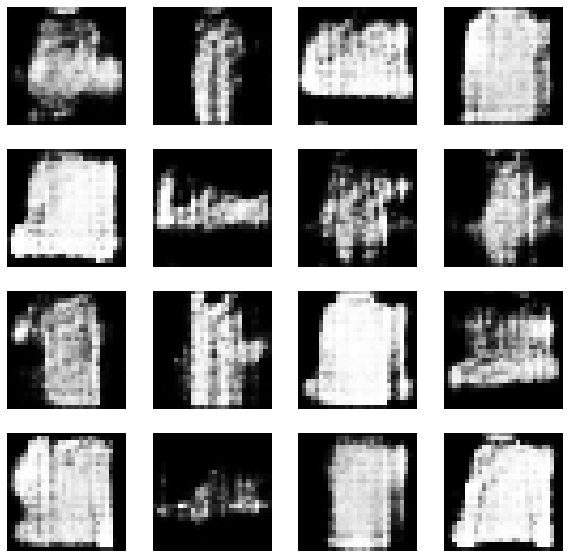

Epoca:  57


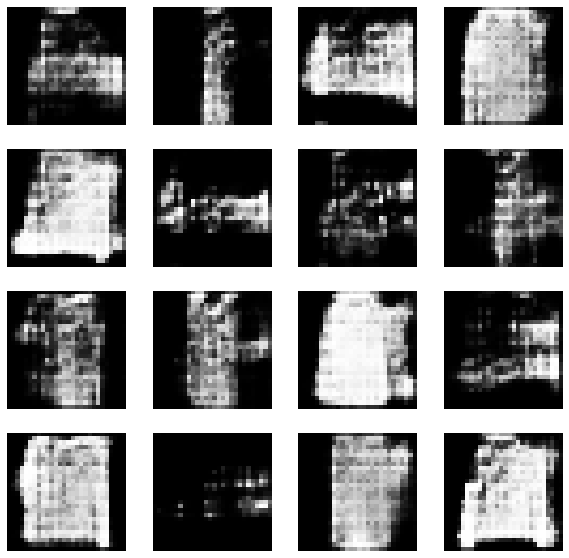

Epoca:  58


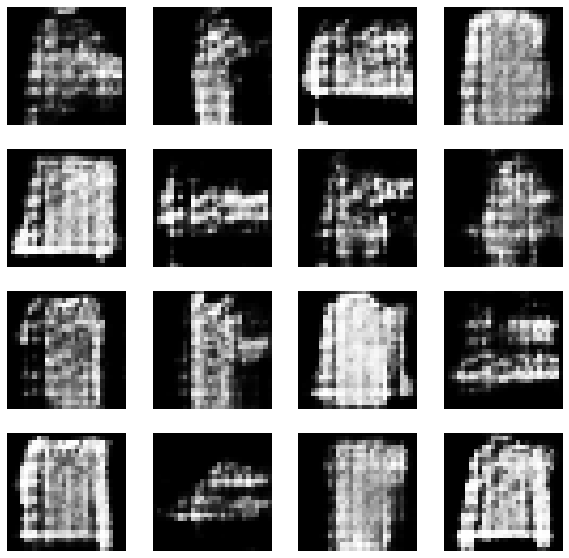

Epoca:  59


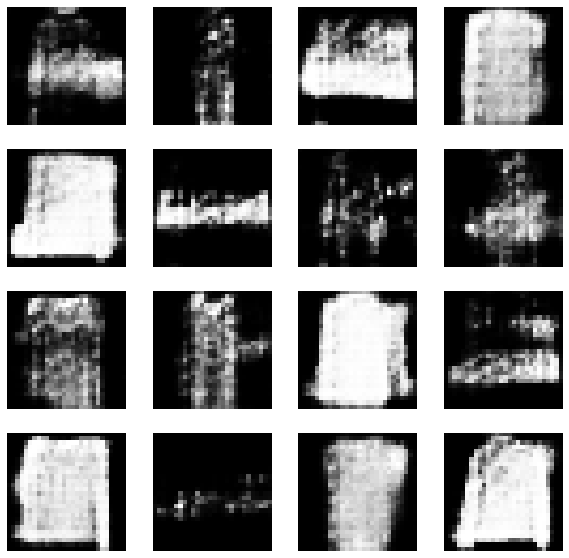

Epoca:  60


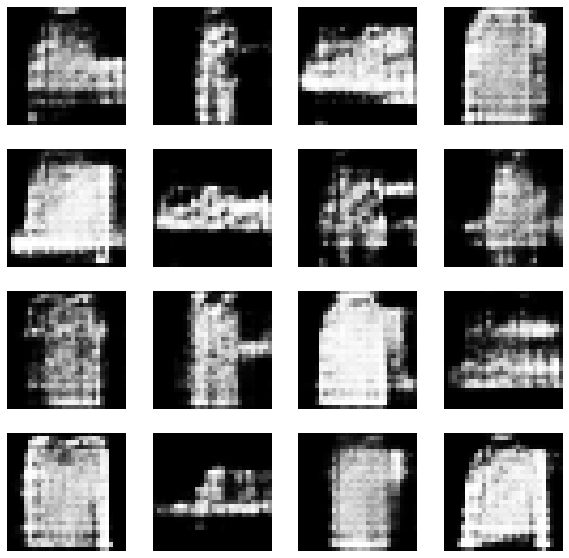

Epoca:  61


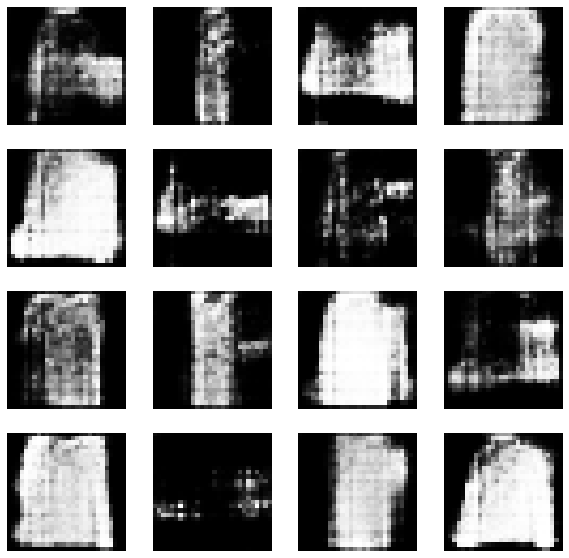

Epoca:  62


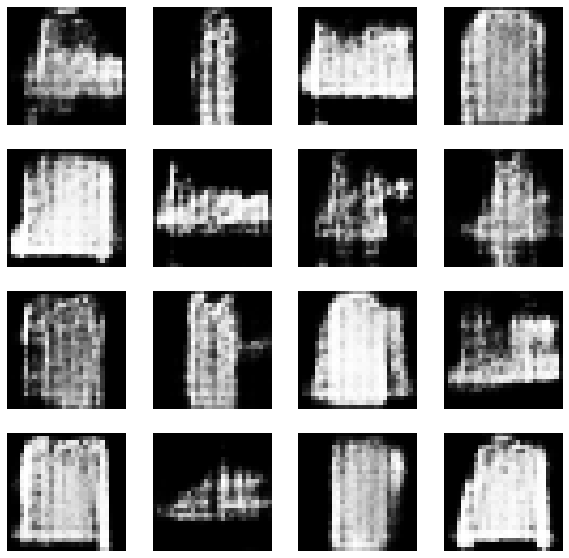

Epoca:  63


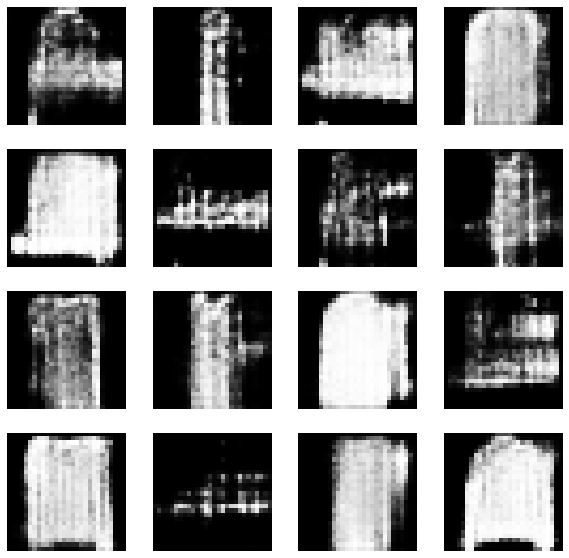

Epoca:  64


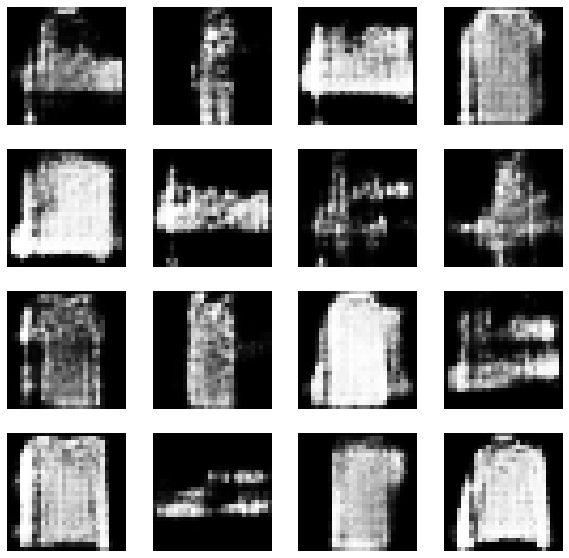

Epoca:  65


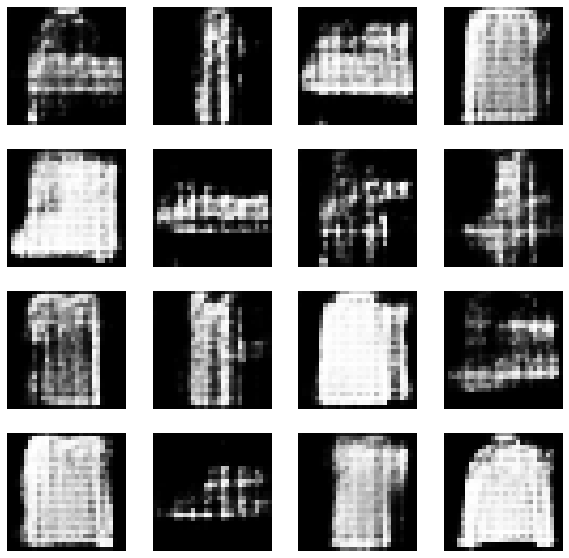

Epoca:  66


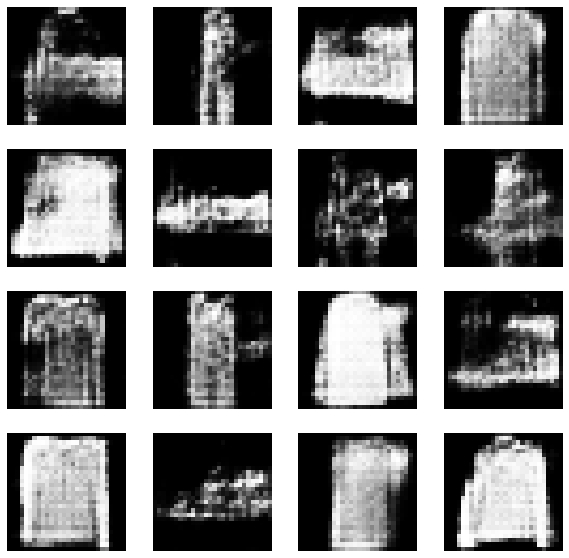

Epoca:  67


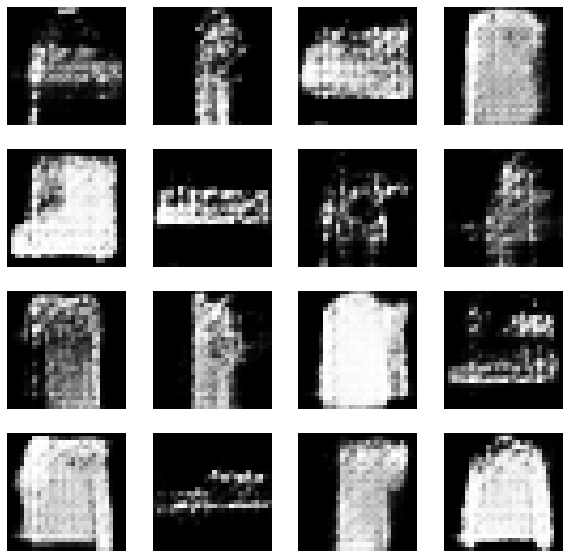

Epoca:  68


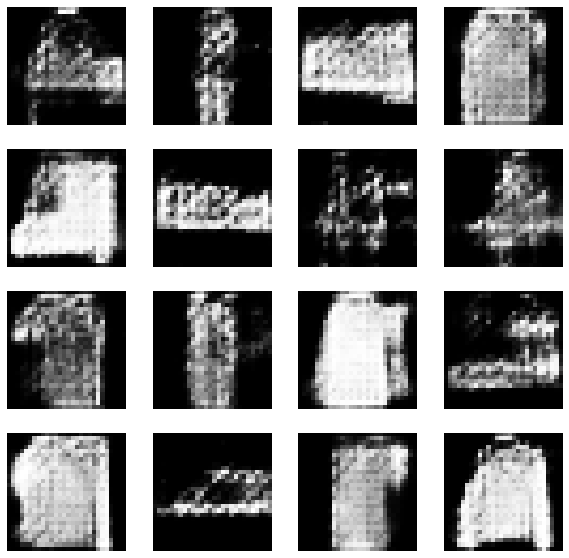

Epoca:  69


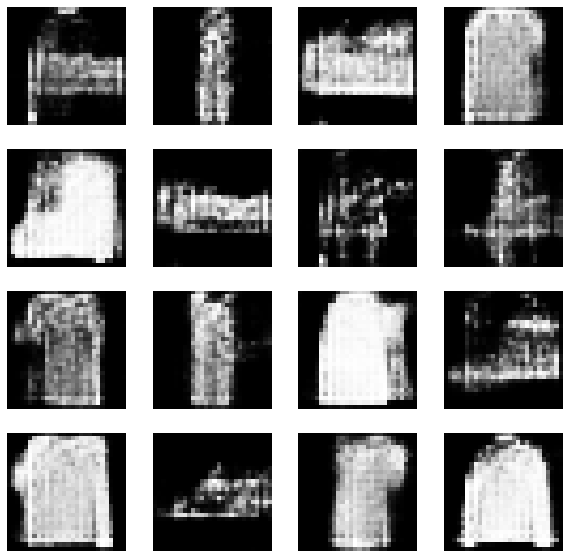

Epoca:  70


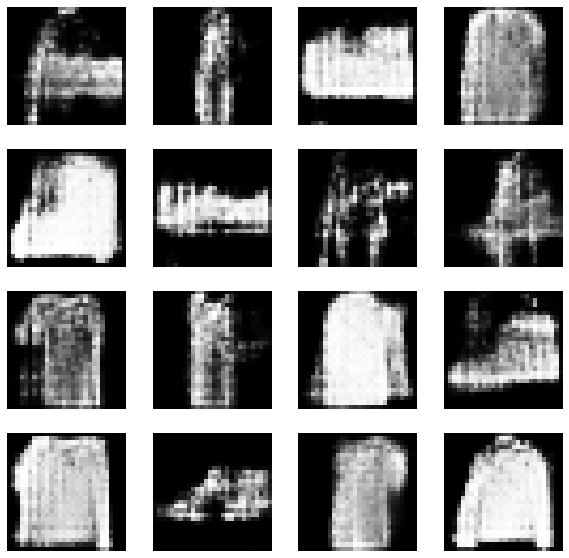

Epoca:  71


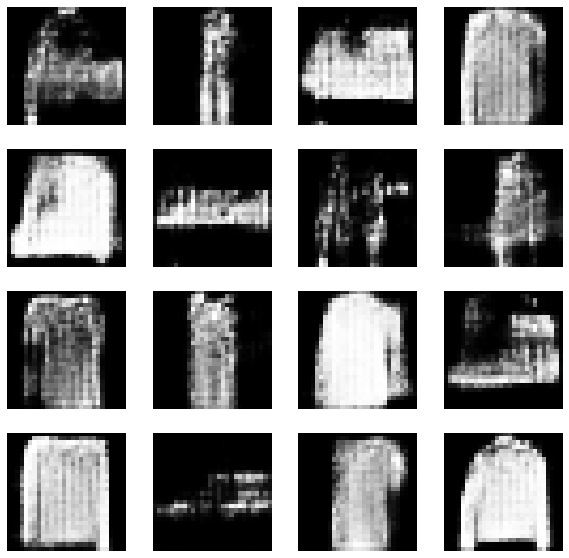

Epoca:  72


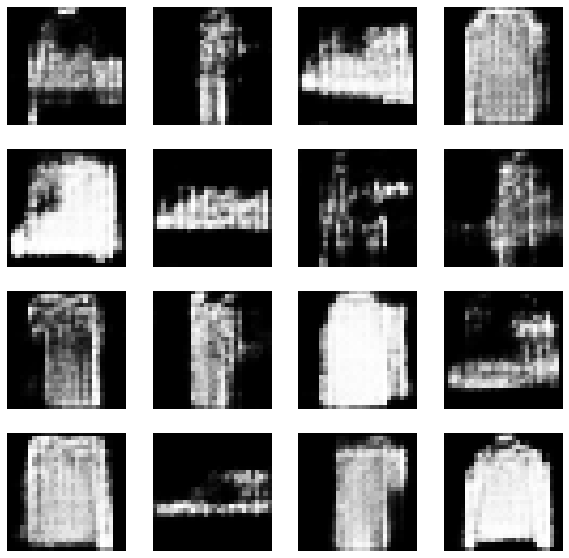

Epoca:  73


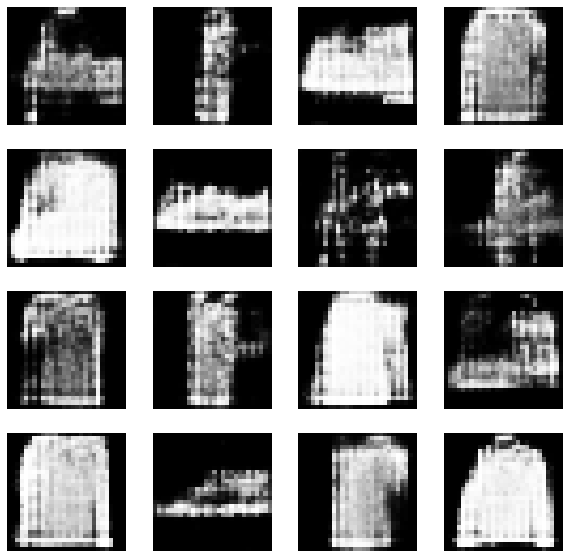

Epoca:  74


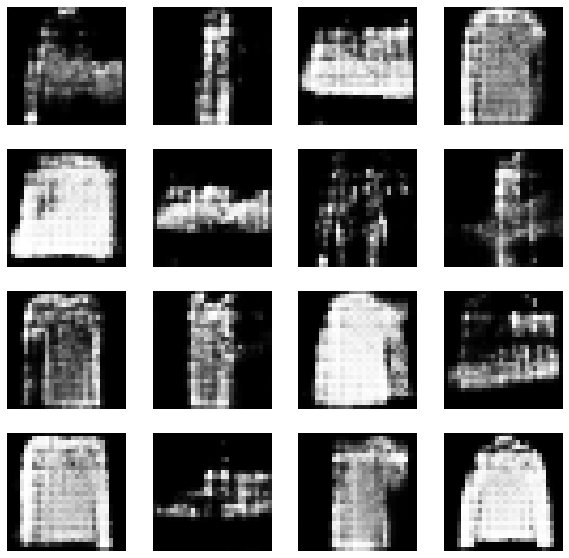

Epoca:  75


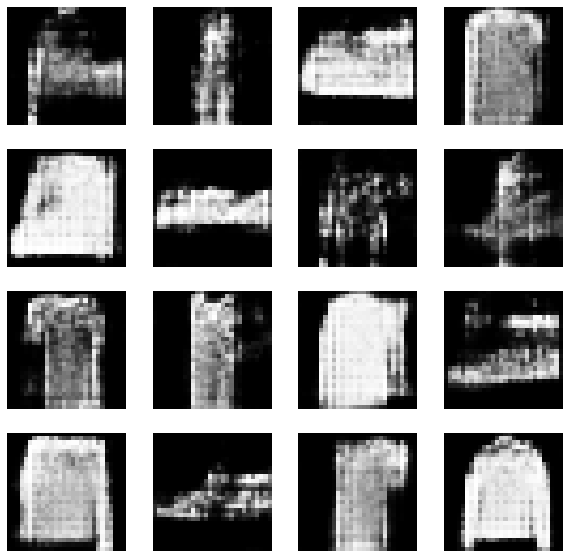

Epoca:  76


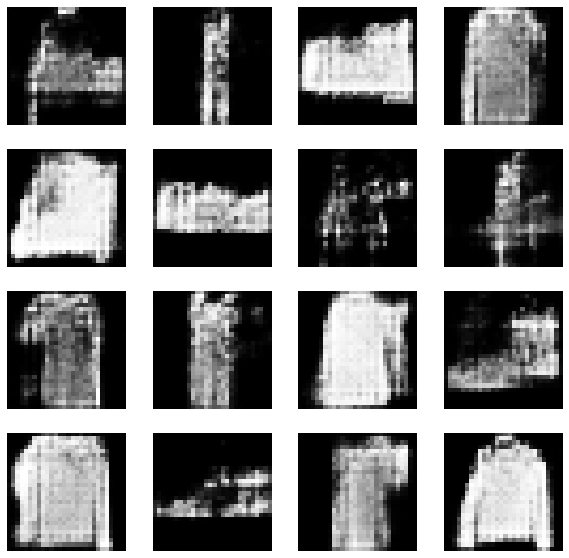

Epoca:  77


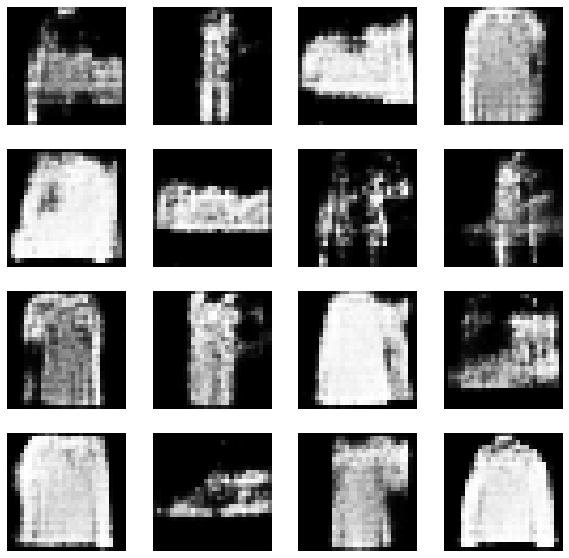

Epoca:  78


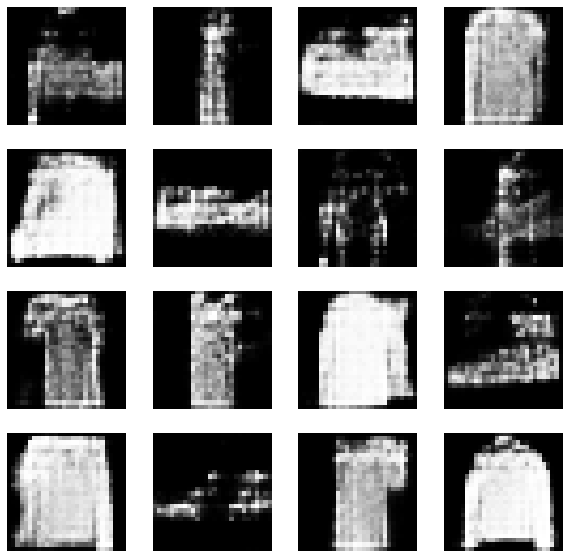

Epoca:  79


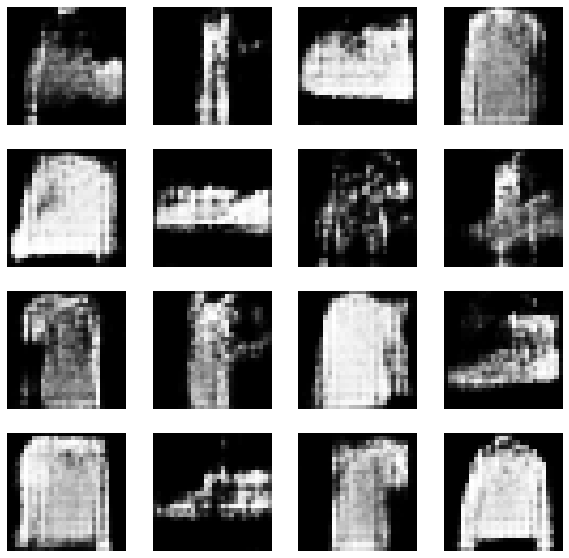

Epoca:  80


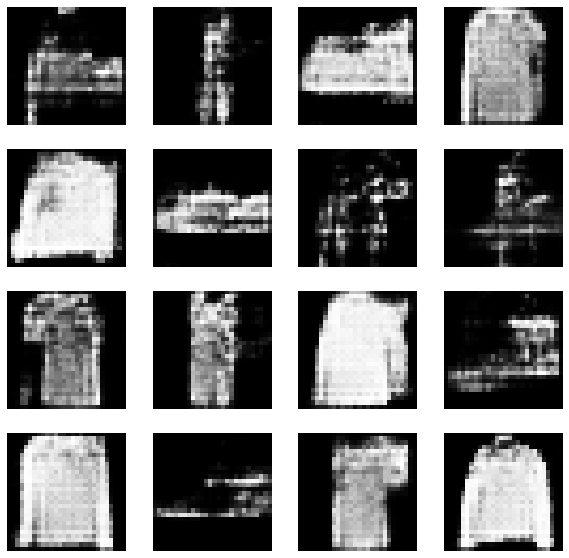

Epoca:  81


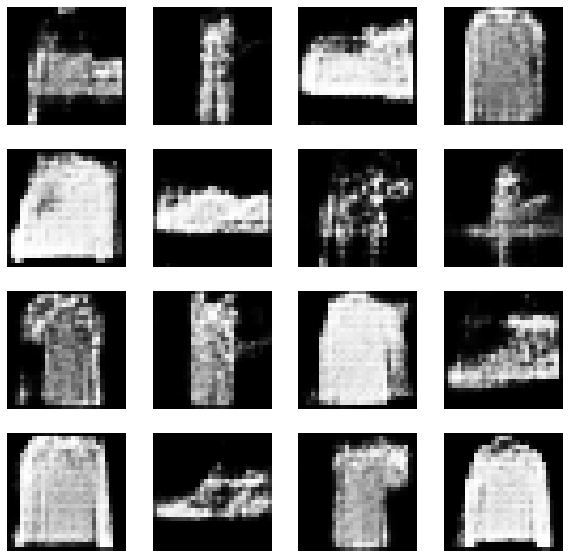

Epoca:  82


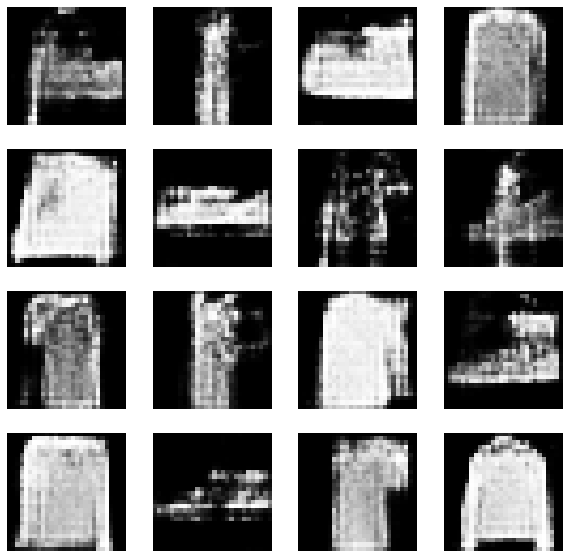

Epoca:  83


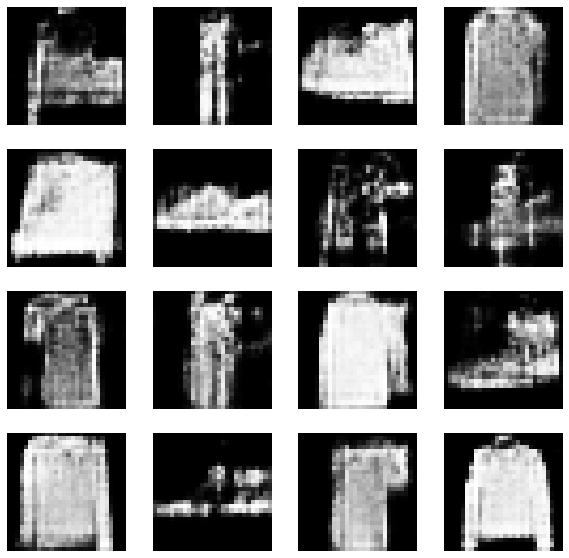

Epoca:  84


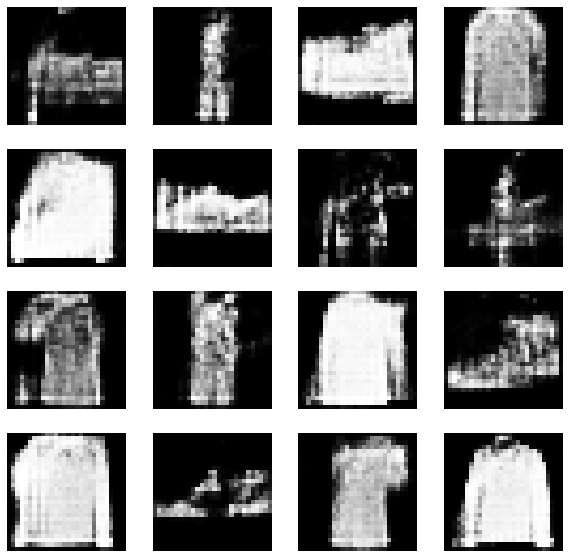

Epoca:  85


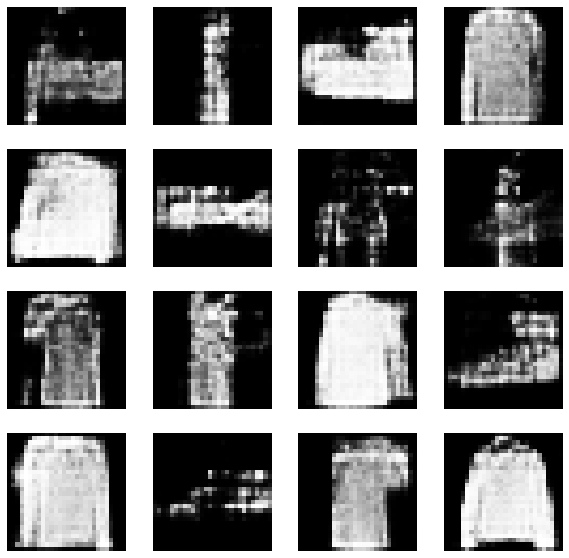

Epoca:  86


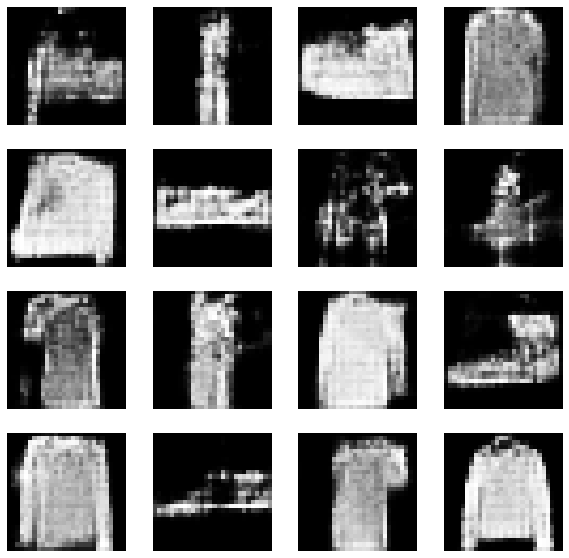

Epoca:  87


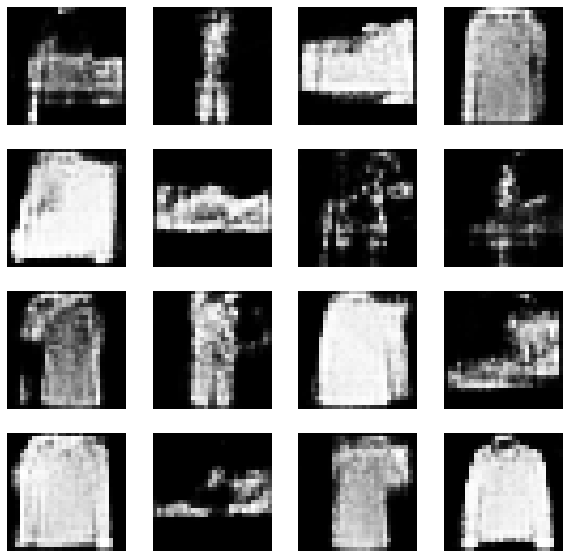

Epoca:  88


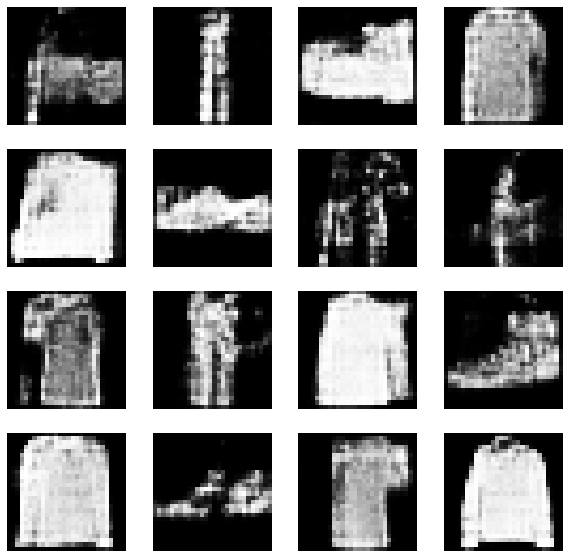

Epoca:  89


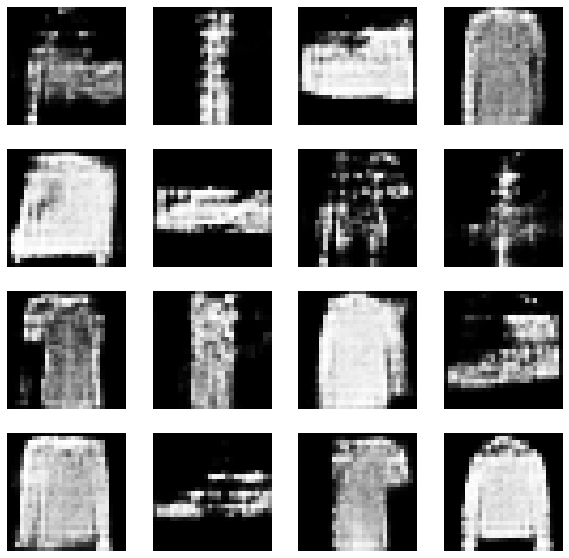

Epoca:  90


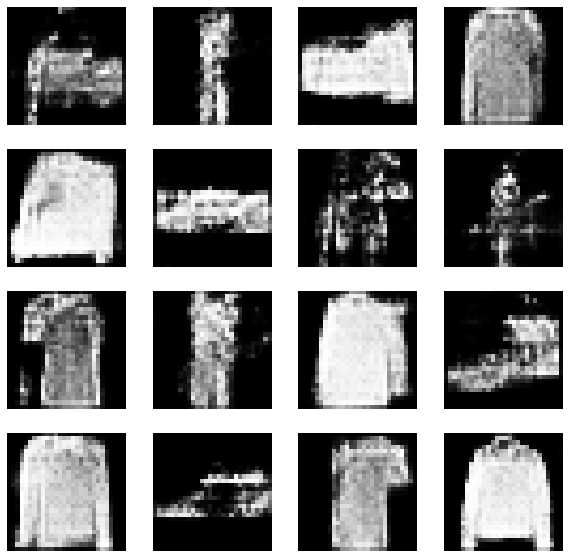

Epoca:  91


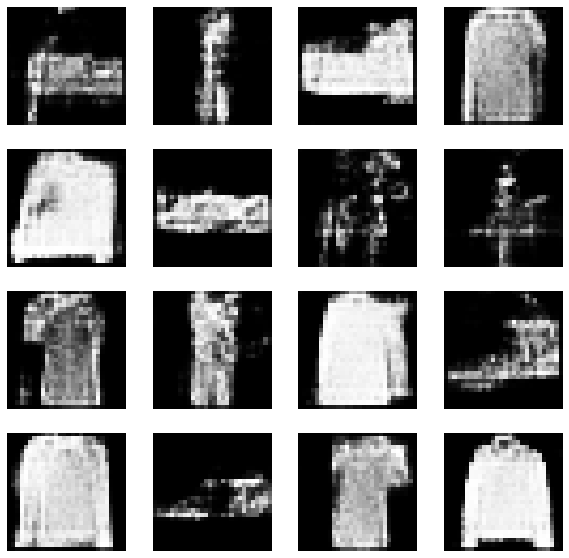

Epoca:  92


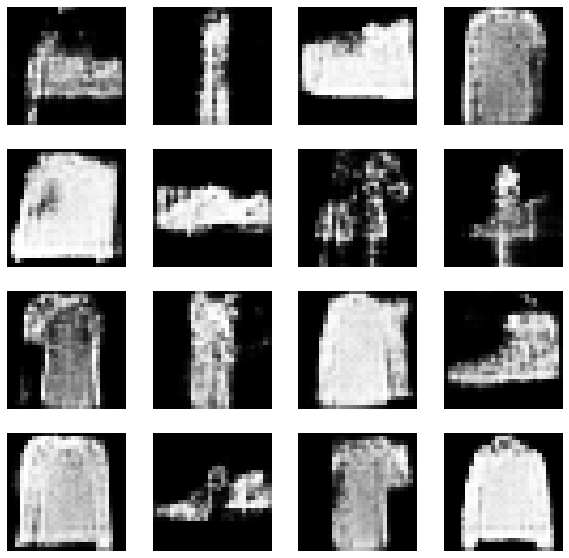

Epoca:  93


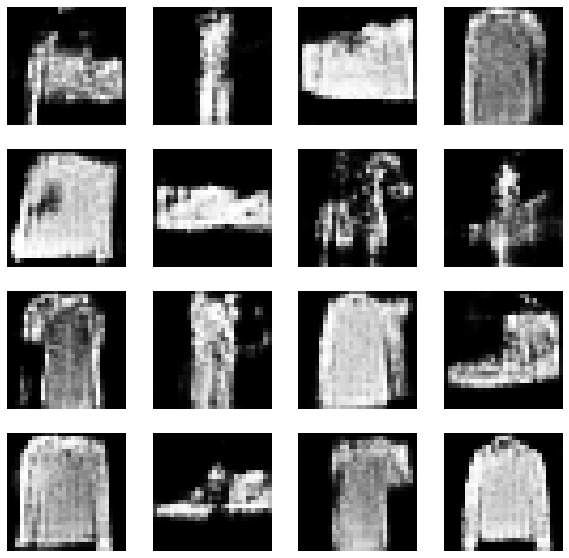

Epoca:  94


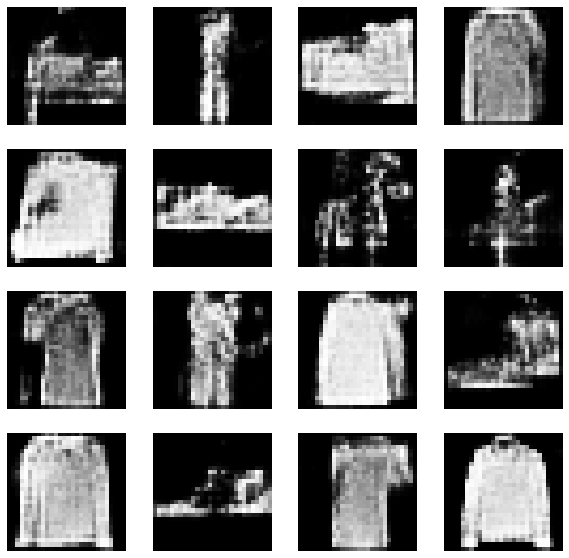

Epoca:  95


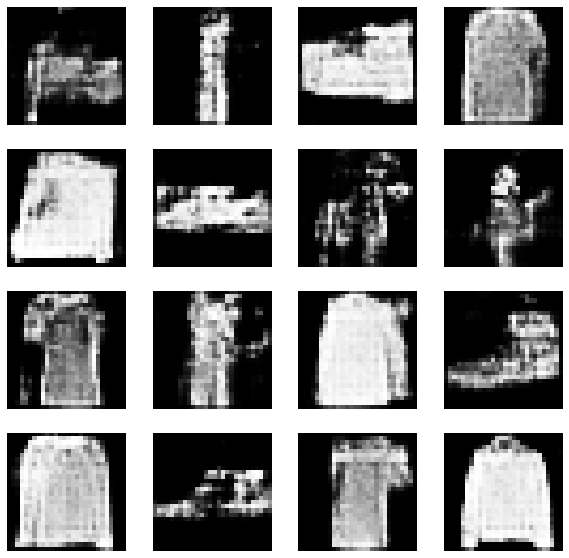

Epoca:  96


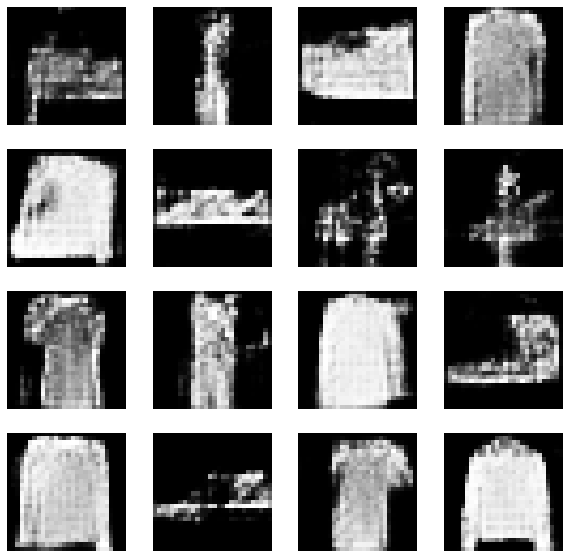

Epoca:  97


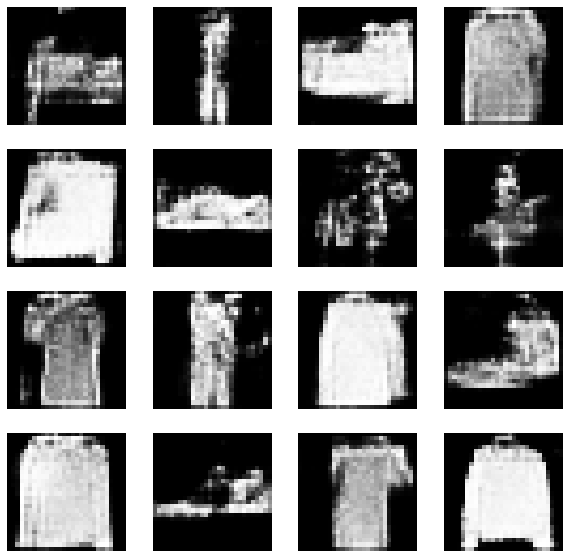

Epoca:  98


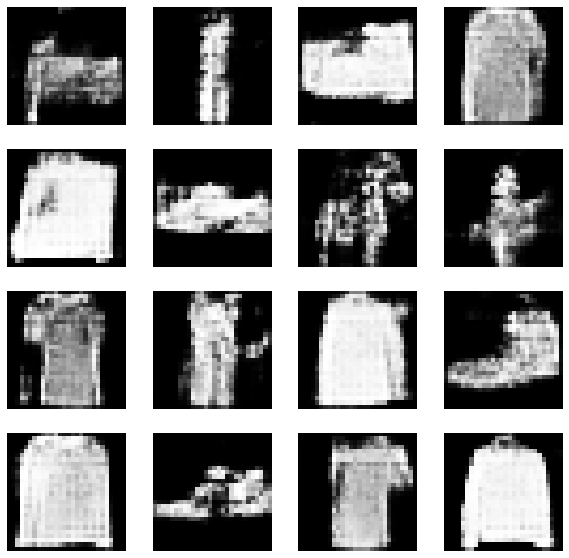

Epoca:  99


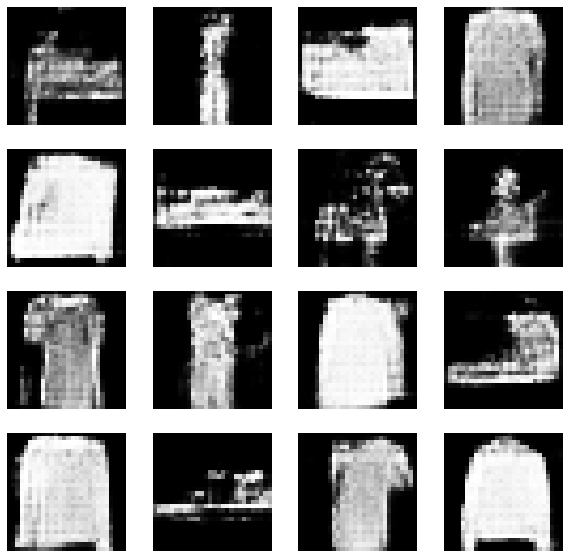

Epoca:  100


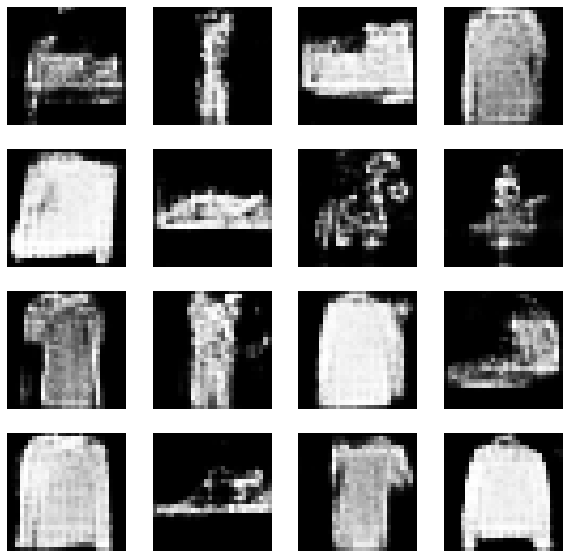

In [30]:
treina_gan(x_treinamento,epocas,imagens_teste)